In [ ]:
# Conecting my google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results

/content/drive/MyDrive/Diss_Code/Final_Results


## Packages

In [ ]:
%pip install pandas

In [ ]:
%pip install scipy

In [ ]:
import pandas as pd
import numpy as np
import ast
import torch
from scipy.spatial.distance import euclidean
from itertools import dropwhile
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns

Making sure that I have a good data analysis set up going on

## Test 1

##### Directory

In [ ]:
%cd Kool_Leuven1

/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Kool_Leuven1


##### Reading in Solutions

In [ ]:
df = pd.read_csv('Leuven1_test_1_cvrp_20_Kool.csv')

In [ ]:
df['Sequence'] = df['Sequence'].apply(ast.literal_eval)

##### Reading in OG dataset

In [ ]:
# Need to read in the original location points so i can calculate the actual distances you know
# This is going to be especially important for the normalised datasets
%cd /Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Original/Initial_Dictionaries

/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Original/Initial_Dictionaries


In [ ]:
df_og = pd.read_csv('Leuven1_depot.csv').transpose()

In [ ]:
df_og[0] = df_og[0].apply(ast.literal_eval)

# The data is saved as strings so have to turn it back into lists and ints

Ok making columns of the depot and the customers seperatley

In [ ]:
def extract_depot(coordinates):
    return coordinates[0]

# Function to extract the customer coordinates from the format
def extract_customers(coordinates):
    return coordinates[1]

# Apply the functions to create new columns
df_og['depot'] = df_og[0].apply(extract_depot)
df_og['customers'] = df_og[0].apply(extract_customers)

# Drop the original 'coordinates' column if needed
df_og.drop(columns=0, inplace=True)

In [ ]:
# df_og

Now combining the two into one list where the depot is at index 0

In [ ]:
def combine_depot_and_customers(row):
    return [row['depot']] + row['customers']

# Apply the function to create the new 'full' column
df_og['full'] = df_og.apply(combine_depot_and_customers, axis=1)

In [ ]:
df_og_full = df_og[['full']].reset_index(drop=True)

In [ ]:
# df_og_full

In [ ]:
df_seq = df[['Sequence', 'Cluster Number']]

In [ ]:
merged_df = df_seq.merge(df_og_full, left_index=True, right_index=True)

In [ ]:
# merged_df.head()

Ok now I have to calculate costs for each cluster which is using the sequence as the index

Maybe the best idea is to create a new column called ordered full

So I have a column called sequence that contains rows with data denoted by [0,3,2,4,1] and i have another column called full with rows that has data denoted by [[1,2],[3,4],[1,2],[3,4],[5,6]].
The values in sequence represent the order of the indexes in full. How can i reorder the full column values such that they are in order according to sequences.

In [ ]:
def reorder_full(row):
    return [row['full'][i] for i in row['Sequence']]

# Apply the function to create the new 'reordered_full' column
merged_df['reordered_full'] = merged_df.apply(reorder_full, axis=1)

In [ ]:
def calculate_euclidean_distances(row):
    distances = []
    for i in range(len(row) - 1):
        distances.append(euclidean(row[i], row[i+1]))
    return distances

merged_df['euclidean_distances'] = merged_df['reordered_full'].apply(calculate_euclidean_distances)

In [ ]:
total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

In [ ]:
# Still need to add the distances from the depot to the first point and from the last point to the depot
# merged_df.head()

Ok now i want to take the first and last values in reordered_full and calculate the Euclidean distance between these values and the first value in full. So basically i want Euclidean distance of reordered_full[0] and full[0] and the euclidean distance of reordered_full[-1] and full[0]

In [ ]:
def calculate_first_last_distance(row):
    first_point = row[0]
    last_point = row[-1]
    first_full_point = merged_df['full'].iloc[0][0]
    return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

# Apply the function to calculate distances and create new columns
merged_df[['first_to_first_distance', 'last_to_first_distance']] = merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

In [ ]:
total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

In [ ]:
total_distance += merged_df['first_to_first_distance'].sum() + merged_df['last_to_first_distance'].sum()

In [ ]:
import pandas as pd
from scipy.spatial.distance import euclidean
import ast

def read_csv_files(sequence_file_path, depot_file_path):
    df = pd.read_csv(sequence_file_path)
    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)

    df_og = pd.read_csv(depot_file_path).transpose()
    df_og[0] = df_og[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    def extract_customers(coordinates):
        return coordinates[1]

    df_og['depot'] = df_og[0].apply(extract_depot)
    df_og['customers'] = df_og[0].apply(extract_customers)

    df_og.drop(columns=0, inplace=True)

    df_og['full'] = df_og.apply(lambda row: [row['depot']] + row['customers'], axis=1)

    return df, df_og

def calculate_total_cost_and_sequence(sequence_file_path, depot_file_path):
    df_with_results, df_original_data = read_csv_files(sequence_file_path, depot_file_path)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    reordered_full_df = merged_df.apply(reorder_full, axis=1).apply(pd.Series)

    merged_df = pd.concat([merged_df, reordered_full_df], axis=1)

    def calculate_euclidean_distances(row):
        distances = []
        for i in range(len(row) - 1):
            distances.append(euclidean(row[i], row[i+1]))
        return distances

    merged_df['euclidean_distances'] = merged_df['reordered_full'].apply(calculate_euclidean_distances)

    def calculate_first_last_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    merged_df[['first_to_first_distance', 'last_to_first_distance']] = merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()
    total_distance += merged_df['first_to_first_distance'].sum() + merged_df['last_to_first_distance'].sum()

    return total_distance, merged_df[['Sequence', 'Cluster Number']]

# Example usage:
sequence_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Kool_Leuven1/Leuven1_test_1_cvrp_20_Kool.csv'
depot_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Original/Initial_Dictionaries/Leuven1_depot.csv'
total_cost, sequence_cluster_df = calculate_total_cost_and_sequence(sequence_file_path, depot_file_path)

print("Total Cost:", total_cost)
print("Sequence and Cluster Number DataFrame:")
print(sequence_cluster_df)


KeyError: 'reordered_full'

In [ ]:
def read_csv_files(sequence_file_path, depot_file_path):
    df = pd.read_csv(sequence_file_path)
    df['Sequence'] = df['Sequence'].apply(ast.literal_eval)

    df_og = pd.read_csv(depot_file_path).transpose()
    df_og[0] = df_og[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    def extract_customers(coordinates):
        return coordinates[1]

    df_og['depot'] = df_og[0].apply(extract_depot)
    df_og['customers'] = df_og[0].apply(extract_customers)

    df_og.drop(columns=0, inplace=True)

    df_og['full'] = df_og.apply(lambda row: [row['depot']] + row['customers'], axis=1)

    return df, df_og

In [ ]:
poop, peep = read_csv_files(sequence_file_path, depot_file_path)

In [ ]:
def calculate_total_cost_and_sequence(sequence_file_path, depot_file_path):
    df_with_results, df_original_data = read_csv_files(sequence_file_path, depot_file_path)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    reordered_full_df = merged_df.apply(reorder_full, axis=1).apply(pd.Series)

    # merged_df = pd.concat([merged_df, reordered_full_df], axis=1)

    # def calculate_euclidean_distances(row):
    #     distances = []
    #     for i in range(len(row) - 1):
    #         distances.append(euclidean(row[i], row[i+1]))
    #     return distances

    # merged_df['euclidean_distances'] = merged_df['reordered_full'].apply(calculate_euclidean_distances)

    # def calculate_first_last_distance(row):
    #     first_point = row[0]
    #     last_point = row[-1]
    #     first_full_point = merged_df['full'].iloc[0][0]
    #     return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    # merged_df[['first_to_first_distance', 'last_to_first_distance']] = merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    # total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()
    # total_distance += merged_df['first_to_first_distance'].sum() + merged_df['last_to_first_distance'].sum()

    # return total_distance, merged_df[['Sequence', 'Cluster Number']]
    return merged_df, reordered_full_df

In [ ]:
poop = calculate_total_cost_and_sequence(sequence_file_path, depot_file_path)

In [ ]:
poop

(                                             Sequence  Cluster Number  \
 0   [78, 20, 8, 9, 50, 55, 59, 39, 83, 29, 0, 67, ...               0   
 1   [59, 18, 81, 39, 78, 8, 73, 84, 58, 56, 62, 0,...               1   
 2   [40, 3, 14, 12, 32, 6, 4, 10, 24, 39, 55, 21, ...               2   
 3   [71, 69, 37, 27, 70, 67, 23, 0, 38, 40, 64, 72...               3   
 4   [125, 47, 40, 60, 161, 113, 28, 52, 0, 104, 96...               4   
 5   [24, 25, 44, 23, 20, 34, 0, 28, 7, 39, 38, 55,...               5   
 6   [27, 25, 17, 54, 30, 12, 22, 49, 32, 4, 0, 51,...               6   
 7   [61, 28, 67, 76, 14, 17, 73, 10, 24, 44, 55, 3...               7   
 8   [74, 82, 51, 24, 100, 63, 0, 96, 57, 49, 45, 8...               8   
 9   [75, 67, 80, 40, 7, 61, 83, 41, 0, 97, 39, 55,...               9   
 10  [71, 21, 39, 29, 35, 19, 58, 26, 60, 0, 18, 50...              10   
 11  [37, 64, 70, 10, 40, 25, 55, 21, 29, 42, 51, 0...              11   
 12  [5, 16, 13, 35, 52, 38, 27, 34, 1

In [ ]:
%cd /Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh

/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh


In [ ]:
!python analysis.py  'Thesis Documents/Results/Kool_Leuven1/Leuven1_test_1_cvrp_20_Kool.csv' 'Thesis Documents/Results/Original/Initial_Dictionaries/Leuven1_depot.csv'

                                             Sequence  ...                                               full
0   [78, 20, 8, 9, 50, 55, 59, 39, 83, 29, 0, 67, ...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
1   [59, 18, 81, 39, 78, 8, 73, 84, 58, 56, 62, 0,...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
2   [40, 3, 14, 12, 32, 6, 4, 10, 24, 39, 55, 21, ...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
3   [71, 69, 37, 27, 70, 67, 23, 0, 38, 40, 64, 72...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
4   [125, 47, 40, 60, 161, 113, 28, 52, 0, 104, 96...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
5   [24, 25, 44, 23, 20, 34, 0, 28, 7, 39, 38, 55,...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
6   [27, 25, 17, 54, 30, 12, 22, 49, 32, 4, 0, 51,...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
7   [61, 28, 67, 76, 14, 17, 73, 10, 24, 44, 55, 3...  ...  [[0.3678402522333158, 0.5254860746190226], [[0...
8   [74, 8

In [ ]:
sequence_file_path = 'Thesis Documents/Results/Kool_Leuven1/Leuven1_test_1_cvrp_20_Kool.csv'
original_file_path = 'Thesis Documents/Results/Original/Initial_Dictionaries/Leuven1_depot.csv'

# Function for straight up depot to cluster model

In [ ]:
def massive_function_kool(sequence_file_path, original_file_path):

    df_with_results = pd.read_csv(sequence_file_path)

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(ast.literal_eval)

    df_original_data = pd.read_csv(original_file_path).transpose()

    df_original_data[0] = df_original_data[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    # Function to extract the customer coordinates from the format
    def extract_customers(coordinates):
        return coordinates[1]

    # Apply the functions to create new columns
    df_original_data['depot'] = df_original_data[0].apply(extract_depot)
    df_original_data['customers'] = df_original_data[0].apply(extract_customers)

    # Drop the original 'coordinates' column if needed
    df_original_data.drop(columns=0, inplace=True)

    def combine_depot_and_customers(row):
        return [row['depot']] + row['customers']

    # Apply the function to create the new 'full' column
    df_original_data['full'] = df_original_data.apply(combine_depot_and_customers, axis=1)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    # Apply the function to create the new 'reordered_full' column
    merged_df['reordered_full'] = merged_df.apply(reorder_full, axis=1)

    def calculate_euclidean_distances(row):
        distances = []
        for i in range(len(row) - 1):
            distances.append(euclidean(row[i], row[i+1]))
        return distances

    merged_df['euclidean_distances'] = merged_df['reordered_full'].apply(calculate_euclidean_distances)

    total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    def calculate_first_last_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    # Apply the function to calculate distances and create new columns
    merged_df[['first_to_first_distance', 'last_to_first_distance']] = merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    total_distance += merged_df['first_to_first_distance'].sum() + merged_df['last_to_first_distance'].sum()

    return total_distance, merged_df

##### Testing the function

In [ ]:
sequence_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Kool_Leuven1/Leuven1_test_3_cvrp_20_Kool.csv'


In [ ]:
cost, frame = massive_function(sequence_file_path, depot_file_path)

# Function for depot to centroid model

So the OG function will perform the distance calculation for intermediate depots but we need to add in the actual depot

In [ ]:
def massive_function_centroid_kool(sequence_file_path, original_file_path, depot_file_path):

    df_with_results = pd.read_csv(sequence_file_path)

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(ast.literal_eval)

    df_original_data = pd.read_csv(original_file_path).transpose()

    df_depot = pd.read_csv(depot_file_path).transpose().reset_index(drop=True)

    df_original_data[0] = df_original_data[0].apply(ast.literal_eval)

    df_depot[0] = df_depot[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    # Function to extract the customer coordinates from the format
    def extract_customers(coordinates):
        return coordinates[1]

    # Apply the functions to create new columns
    df_original_data['depot'] = df_original_data[0].apply(extract_depot)
    df_depot['depot'] = df_depot[0].apply(extract_depot)
    df_original_data['customers'] = df_original_data[0].apply(extract_customers)

    # Drop the original 'coordinates' column if needed
    df_original_data.drop(columns=0, inplace=True)
    df_depot.drop(columns=0, inplace=True)

    def combine_depot_and_customers(row):
        return [row['depot']] + row['customers']

    # Apply the function to create the new 'full' column
    df_original_data['full'] = df_original_data.apply(combine_depot_and_customers, axis=1)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    extra_merged_df = merged_df.merge(df_depot[['depot']], left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    # Apply the function to create the new 'reordered_full' column
    extra_merged_df['reordered_full'] = extra_merged_df.apply(reorder_full, axis=1)

    def calculate_distance_between_depot_and_centroid(row):
        full_list = row['full']
        depot = row['depot']
        # Only get the first point in the full_list
        first_point = full_list[0]
        return euclidean(depot, first_point)

    extra_merged_df['distances'] = extra_merged_df.apply(calculate_distance_between_depot_and_centroid, axis=1)

    def count_zeros(sequence):
        # Exclude first and last elements
        sequence = sequence[1:-1]
        return sequence.count(0)

    extra_merged_df['zero_count'] = extra_merged_df['Sequence'].apply(count_zeros)

    extra_merged_df['product'] = extra_merged_df['zero_count']*extra_merged_df['distances']

    def calculate_euclidean_distances(row):
        distances = []
        for i in range(len(row) - 1):
            distances.append(euclidean(row[i], row[i+1]))
        return distances

    extra_merged_df['euclidean_distances'] = extra_merged_df['reordered_full'].apply(calculate_euclidean_distances)

    total_distance = extra_merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    def calculate_first_last_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = extra_merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    def calculate_depot_to_centroid_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = extra_merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    # Apply the function to calculate distances and create new columns
    extra_merged_df[['first_to_first_distance', 'last_to_first_distance']] = extra_merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    total_distance = extra_merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    total_distance += extra_merged_df['first_to_first_distance'].sum() + extra_merged_df['last_to_first_distance'].sum() + extra_merged_df['product'].sum()

    return total_distance, extra_merged_df
    # return df_depot

In [ ]:
sequence_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Kool_Leuven1/Leuven1_test_4_cvrp_20_Kool.csv'
original_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Original/Initial_Dictionaries/Leuven1_centroid.csv'
depot_file_path = '/Users/matthewrosenthal/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Thesis Documents/Results/Original/Initial_Dictionaries/Leuven1_depot.csv'

In [ ]:
dis, df= massive_function_centroid(sequence_file_path, original_file_path, depot_file_path)

# MDAM Version (This one should be used for Stepwise also)

Have to remove the zeros at the end of the sequences in MDAM

## Straight Up Version

In [ ]:
def massive_function_MDAM(sequence_file_path, original_file_path):

    df_with_results = pd.read_csv(sequence_file_path)

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(ast.literal_eval)

    def drop_trailing_zeros(sequence):
    # Extract the sequence from the list
        while sequence and sequence[-1] == 0:
            sequence = sequence[:-1]
        # Return a list with the cleaned sequence
        return sequence

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(lambda x: x[0])

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(drop_trailing_zeros)

    df_original_data = pd.read_csv(original_file_path).transpose()

    df_original_data[0] = df_original_data[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    # Function to extract the customer coordinates from the format
    def extract_customers(coordinates):
        return coordinates[1]

    # Apply the functions to create new columns
    df_original_data['depot'] = df_original_data[0].apply(extract_depot)
    df_original_data['customers'] = df_original_data[0].apply(extract_customers)

    # Drop the original 'coordinates' column if needed
    df_original_data.drop(columns=0, inplace=True)

    def combine_depot_and_customers(row):
        return [row['depot']] + row['customers']

    # Apply the function to create the new 'full' column
    df_original_data['full'] = df_original_data.apply(combine_depot_and_customers, axis=1)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    # Apply the function to create the new 'reordered_full' column
    merged_df['reordered_full'] = merged_df.apply(reorder_full, axis=1)

    def calculate_euclidean_distances(row):
        distances = []
        for i in range(len(row) - 1):
            distances.append(euclidean(row[i], row[i+1]))
        return distances

    merged_df['euclidean_distances'] = merged_df['reordered_full'].apply(calculate_euclidean_distances)

    total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    def calculate_first_last_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    # Apply the function to calculate distances and create new columns
    merged_df[['first_to_first_distance', 'last_to_first_distance']] = merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    total_distance = merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    total_distance += merged_df['first_to_first_distance'].sum() + merged_df['last_to_first_distance'].sum()

    return total_distance, merged_df

## Centroid Version

In [ ]:
def massive_function_centroid_MDAM(sequence_file_path, original_file_path, depot_file_path):

    df_with_results = pd.read_csv(sequence_file_path)

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(ast.literal_eval)

    def drop_trailing_zeros(sequence):
    # Extract the sequence from the list
        while sequence and sequence[-1] == 0:
            sequence = sequence[:-1]
        # Return a list with the cleaned sequence
        return sequence

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(lambda x: x[0])

    df_with_results['Sequence'] = df_with_results['Sequence'].apply(drop_trailing_zeros)

    df_original_data = pd.read_csv(original_file_path).transpose()

    df_depot = pd.read_csv(depot_file_path).transpose().reset_index(drop=True)

    df_original_data[0] = df_original_data[0].apply(ast.literal_eval)

    df_depot[0] = df_depot[0].apply(ast.literal_eval)

    def extract_depot(coordinates):
        return coordinates[0]

    # Function to extract the customer coordinates from the format
    def extract_customers(coordinates):
        return coordinates[1]

    # Apply the functions to create new columns
    df_original_data['depot'] = df_original_data[0].apply(extract_depot)
    df_depot['depot'] = df_depot[0].apply(extract_depot)
    df_original_data['customers'] = df_original_data[0].apply(extract_customers)

    # Drop the original 'coordinates' column if needed
    df_original_data.drop(columns=0, inplace=True)
    df_depot.drop(columns=0, inplace=True)

    def combine_depot_and_customers(row):
        return [row['depot']] + row['customers']

    # Apply the function to create the new 'full' column
    df_original_data['full'] = df_original_data.apply(combine_depot_and_customers, axis=1)

    df_original_full = df_original_data[['full']].reset_index(drop=True)

    df_only_sequences = df_with_results[['Sequence', 'Cluster Number']]

    merged_df = df_only_sequences.merge(df_original_full, left_index=True, right_index=True)

    extra_merged_df = merged_df.merge(df_depot[['depot']], left_index=True, right_index=True)

    def reorder_full(row):
        return [row['full'][i] for i in row['Sequence']]

    # Apply the function to create the new 'reordered_full' column
    extra_merged_df['reordered_full'] = extra_merged_df.apply(reorder_full, axis=1)

    def calculate_distance_between_depot_and_centroid(row):
        full_list = row['full']
        depot = row['depot']
        # Only get the first point in the full_list
        first_point = full_list[0]
        return euclidean(depot, first_point)

    extra_merged_df['distances'] = extra_merged_df.apply(calculate_distance_between_depot_and_centroid, axis=1)

    def count_zeros(sequence):
        # Exclude first and last elements
        sequence = sequence[1:-1]
        return sequence.count(0)

    extra_merged_df['zero_count'] = extra_merged_df['Sequence'].apply(count_zeros)

    extra_merged_df['product'] = extra_merged_df['zero_count']*extra_merged_df['distances']

    def calculate_euclidean_distances(row):
        distances = []
        for i in range(len(row) - 1):
            distances.append(euclidean(row[i], row[i+1]))
        return distances

    extra_merged_df['euclidean_distances'] = extra_merged_df['reordered_full'].apply(calculate_euclidean_distances)

    total_distance = extra_merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    def calculate_first_last_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = extra_merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    def calculate_depot_to_centroid_distance(row):
        first_point = row[0]
        last_point = row[-1]
        first_full_point = extra_merged_df['full'].iloc[0][0]
        return euclidean(first_point, first_full_point), euclidean(last_point, first_full_point)

    # Apply the function to calculate distances and create new columns
    extra_merged_df[['first_to_first_distance', 'last_to_first_distance']] = extra_merged_df['reordered_full'].apply(calculate_first_last_distance).apply(pd.Series)

    total_distance = extra_merged_df['euclidean_distances'].apply(lambda x: sum(x)).sum()

    total_distance += extra_merged_df['first_to_first_distance'].sum() + extra_merged_df['last_to_first_distance'].sum() + extra_merged_df['product'].sum()

    return total_distance, extra_merged_df
    # return df_depot

# Testing on Kool, MDAM, and Stepwise datasets

Initial Dictionaries will Always be the same

We'll do the test on Leuven1

Great everything works now we need to figure out how to automate this and then
also append a list or a dictionary with the costs  

In [ ]:
initial_centroid = 'initial_datasets_post_testing/Ghent1_centroid.csv'
initial_depot = 'initial_datasets_post_testing/Ghent1_depot.csv'

#going to have to replace pretty much all of flanders 2

In [ ]:
# Kool
sequence_kool = 'AM_Results/Ghent1/Ghent1_test_4_cvrp_20_Kool.csv'

# MDAM
sequence_MDAM = 'MDAM_Results/Leuven1/Leuven1_test_1_vrp_100_MDAM.csv'

# Stepwise
sequence_step = 'STEPWISE_Results/Flanders2/Flanders2_test_3_cvrp_100_ASWTAM.csv'

cost, df = massive_function_centroid_MDAM(sequence_step, initial_centroid, initial_depot)
cost, df = massive_function_MDAM(sequence_step, initial_depot)

In [ ]:
cost, df = massive_function_kool(sequence_kool, initial_depot)

FileNotFoundError: ignored

In [ ]:
cost

452.23002075957345

In [ ]:
cost, df = massive_function_centroid_kool(sequence_kool, initial_centroid, initial_depot)

FileNotFoundError: ignored

In [ ]:
cost, df = massive_function_MDAM(sequence_MDAM, initial_depot)

In [ ]:
cost, df = massive_function_centroid_MDAM(sequence_MDAM, initial_centroid, initial_depot)

In [ ]:
cost, df = massive_function_MDAM(sequence_step, initial_depot)

In [ ]:
cost, df = massive_function_centroid_MDAM(sequence_step, initial_centroid, initial_depot)

Testing the Benchmarks

In [ ]:
inital_benchmark = 'full_benchmarks_for_post_testing/Antwerp2_full.csv'
MDAM_benchmark_sequence = 'MDAM_Benchmark_Results/Antwerp2_test_1_vrp_20_MDAM.csv'

In [ ]:
cost, df = massive_function_MDAM(MDAM_benchmark_sequence, inital_benchmark)

In [ ]:
cost*1999

599846.2572808091

# Max values for scaling the final costs

In [ ]:
Antwerp1_max = 1999
Antwerp2_max = 1999

Brussels1_max = 1997
Brussels2_max = 1999

Flanders1_max = 26694
Flanders2_max = 26848

Ghent1_max = 1999
Ghent2_max = 1997

Leuven1_max = 1903
Leuven2_max = 1990

# Figuring out how to loop through all the files

## Kool

In [ ]:
import os
import csv

def final_cost_kool(folder_path, output_csv_path, initial_depot, initial_centroid, max_val):

  # Initialize an empty list to store the data
  data_to_write = []

  # Loop through all files in the folder
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
          if 'test_1' in file_path or 'test_3' in file_path:
              cost, df = massive_function_kool(file_path, initial_depot)
          else:
              cost, df = massive_function_centroid_kool(file_path, initial_centroid, initial_depot)

          # Append data to the list
          data_to_write.append([file_path, round(cost * max_val, 2)])

  # Write the data to a CSV file
  with open(output_csv_path, mode='w', newline='') as csv_file:
      csv_writer = csv.writer(csv_file)
      csv_writer.writerow(['File Path', 'Cost'])
      csv_writer.writerows(data_to_write)

  print("Data has been written to", output_csv_path)

In [ ]:
final_cost_kool("AM_Results/Leuven1", 'Leuven1.csv', 'initial_datasets_post_testing/Leuven1_depot.csv',
                'initial_datasets_post_testing/Leuven1_centroid.csv', Leuven1_max)

Data has been written to Leuven1.csv


In [ ]:
final_cost_kool("AM_Results/Leuven2", 'Leuven2.csv', 'initial_datasets_post_testing/Leuven2_depot.csv',
                'initial_datasets_post_testing/Leuven2_centroid.csv', Leuven2_max)

Data has been written to Leuven2.csv


In [ ]:
final_cost_kool("AM_Results/Ghent1", 'Ghent1.csv', 'initial_datasets_post_testing/Ghent1_depot.csv',
                'initial_datasets_post_testing/Ghent1_centroid.csv', Ghent1_max)

Data has been written to Ghent1.csv


In [ ]:
final_cost_kool("AM_Results/Ghent2", 'Ghent2.csv', 'initial_datasets_post_testing/Ghent2_depot.csv',
                'initial_datasets_post_testing/Ghent2_centroid.csv', Ghent2_max)

Data has been written to Ghent2.csv


In [ ]:
final_cost_kool("AM_Results/Brussels1", 'Brussels1.csv', 'initial_datasets_post_testing/Brussels1_depot.csv',
                'initial_datasets_post_testing/Brussels1_centroid.csv', Brussels1_max)

Data has been written to Brussels1.csv


In [ ]:
final_cost_kool("AM_Results/Brussels2", 'Brussels2.csv', 'initial_datasets_post_testing/Brussels2_depot.csv',
                'initial_datasets_post_testing/Brussels2_centroid.csv', Brussels2_max)

Data has been written to Brussels2.csv


In [ ]:
final_cost_kool("AM_Results/Flanders1", 'Flanders1.csv', 'initial_datasets_post_testing/Flanders1_depot.csv',
                'initial_datasets_post_testing/Flanders1_centroid.csv', Flanders1_max)

Data has been written to Flanders1.csv


In [ ]:
final_cost_kool("AM_Results/Flanders2", 'Flanders2.csv', 'initial_datasets_post_testing/Flanders2_depot.csv',
                'initial_datasets_post_testing/Flanders2_centroid.csv', Flanders2_max)

Data has been written to Flanders2.csv


In [ ]:
final_cost_kool("AM_Results/Antwerp1", 'Antwerp1.csv', 'initial_datasets_post_testing/Antwerp1_depot.csv',
                'initial_datasets_post_testing/Antwerp1_centroid.csv', Antwerp2_max)

Data has been written to Antwerp1.csv


In [ ]:
final_cost_kool("AM_Results/Antwerp2", 'Antwerp2.csv', 'initial_datasets_post_testing/Antwerp2_depot.csv',
                'initial_datasets_post_testing/Antwerp2_centroid.csv', Antwerp2_max)

Data has been written to Antwerp2.csv


## MDAM and Step

In [ ]:
def final_cost_MDAM(folder_path, output_csv_path, initial_depot, initial_centroid, max_val):

  # Initialize an empty list to store the data
  data_to_write = []

  # Loop through all files in the folder
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
          if 'test_1' in file_path or 'test_3' in file_path:
              cost, df = massive_function_MDAM(file_path, initial_depot)
          else:
              cost, df = massive_function_centroid_MDAM(file_path, initial_centroid, initial_depot)

          # Append data to the list
          data_to_write.append([file_path, round(cost * max_val, 2)])

  # Write the data to a CSV file
  with open(output_csv_path, mode='w', newline='') as csv_file:
      csv_writer = csv.writer(csv_file)
      csv_writer.writerow(['File Path', 'Cost'])
      csv_writer.writerows(data_to_write)

  print("Data has been written to", output_csv_path)

### Step

In [ ]:
# final_cost_MDAM("STEPWISE_Results/Leuven1", 'Leuven1.csv', 'initial_datasets_post_testing/Leuven1_depot.csv',
#                 'initial_datasets_post_testing/Leuven1_centroid.csv', Leuven1_max)

# final_cost_MDAM("STEPWISE_Results/Leuven2", 'Leuven2.csv', 'initial_datasets_post_testing/Leuven2_depot.csv',
#                 'initial_datasets_post_testing/Leuven2_centroid.csv', Leuven2_max)

# final_cost_MDAM("STEPWISE_Results/Ghent1", 'Ghent1.csv', 'initial_datasets_post_testing/Ghent1_depot.csv',
#                 'initial_datasets_post_testing/Ghent1_centroid.csv', Ghent1_max)

# final_cost_MDAM("STEPWISE_Results/Ghent2", 'Ghent2.csv', 'initial_datasets_post_testing/Ghent2_depot.csv',
#                 'initial_datasets_post_testing/Ghent2_centroid.csv', Ghent2_max)

# final_cost_MDAM("STEPWISE_Results/Brussels1", 'Brussels1.csv', 'initial_datasets_post_testing/Brussels1_depot.csv',
#                 'initial_datasets_post_testing/Brussels1_centroid.csv', Brussels1_max)

# final_cost_MDAM("STEPWISE_Results/Brussels2", 'Brussels2.csv', 'initial_datasets_post_testing/Brussels2_depot.csv',
#                 'initial_datasets_post_testing/Brussels2_centroid.csv', Brussels2_max)

# final_cost_MDAM("STEPWISE_Results/Flanders1", 'Flanders1.csv', 'initial_datasets_post_testing/Flanders1_depot.csv',
#                 'initial_datasets_post_testing/Flanders1_centroid.csv', Flanders1_max)

final_cost_MDAM("STEPWISE_Results/Flanders2", 'Flanders2.csv', 'initial_datasets_post_testing/Flanders2_depot.csv',
                'initial_datasets_post_testing/Flanders2_centroid.csv', Flanders2_max)

# final_cost_MDAM("STEPWISE_Results/Antwerp1", 'Antwerp1.csv', 'initial_datasets_post_testing/Antwerp1_depot.csv',
#                 'initial_datasets_post_testing/Antwerp1_centroid.csv', Antwerp2_max)

# final_cost_MDAM("STEPWISE_Results/Antwerp2", 'Antwerp2.csv', 'initial_datasets_post_testing/Antwerp2_depot.csv',
#                 'initial_datasets_post_testing/Antwerp2_centroid.csv', Antwerp2_max)

Data has been written to Flanders2.csv


### MDAM

In [ ]:
final_cost_MDAM("MDAM_Results/Leuven1", 'Leuven1.csv', 'initial_datasets_post_testing/Leuven1_depot.csv',
                'initial_datasets_post_testing/Leuven1_centroid.csv', Leuven1_max)

final_cost_MDAM("MDAM_Results/Leuven2", 'Leuven2.csv', 'initial_datasets_post_testing/Leuven2_depot.csv',
                'initial_datasets_post_testing/Leuven2_centroid.csv', Leuven1_max)

final_cost_MDAM("MDAM_Results/Ghent1", 'Ghent1.csv', 'initial_datasets_post_testing/Ghent1_depot.csv',
                'initial_datasets_post_testing/Ghent1_centroid.csv', Ghent1_max)

final_cost_MDAM("MDAM_Results/Ghent2", 'Ghent2.csv', 'initial_datasets_post_testing/Ghent2_depot.csv',
                'initial_datasets_post_testing/Ghent2_centroid.csv', Ghent2_max)

final_cost_MDAM("MDAM_Results/Brussels1", 'Brussels1.csv', 'initial_datasets_post_testing/Brussels1_depot.csv',
                'initial_datasets_post_testing/Brussels1_centroid.csv', Brussels1_max)

final_cost_MDAM("MDAM_Results/Brussels2", 'Brussels2.csv', 'initial_datasets_post_testing/Brussels2_depot.csv',
                'initial_datasets_post_testing/Brussels2_centroid.csv', Brussels2_max)

final_cost_MDAM("MDAM_Results/Flanders1", 'Flanders1.csv', 'initial_datasets_post_testing/Flanders1_depot.csv',
                'initial_datasets_post_testing/Flanders1_centroid.csv', Flanders1_max)

final_cost_MDAM("MDAM_Results/Flanders2", 'Flanders2.csv', 'initial_datasets_post_testing/Flanders2_depot.csv',
                'initial_datasets_post_testing/Flanders2_centroid.csv', Flanders2_max)

final_cost_MDAM("MDAM_Results/Antwerp1", 'Antwerp1.csv', 'initial_datasets_post_testing/Antwerp1_depot.csv',
                'initial_datasets_post_testing/Antwerp1_centroid.csv', Antwerp2_max)

final_cost_MDAM("MDAM_Results/Antwerp2", 'Antwerp2.csv', 'initial_datasets_post_testing/Antwerp2_depot.csv',
                'initial_datasets_post_testing/Antwerp2_centroid.csv', Antwerp2_max)

Data has been written to Leuven1.csv
Data has been written to Leuven2.csv
Data has been written to Ghent1.csv
Data has been written to Ghent2.csv
Data has been written to Brussels1.csv
Data has been written to Brussels2.csv
Data has been written to Flanders1.csv
Data has been written to Flanders2.csv
Data has been written to Antwerp1.csv
Data has been written to Antwerp2.csv


In [ ]:
final_cost_MDAM("MDAM_Benchmark_Results/Leuven1", 'Leuven1.csv', 'full_benchmarks_for_post_testing/Leuven1_full.csv',
                None, Leuven1_max)

Data has been written to Leuven1.csv



# Plotting Function for Sequence

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results

/content/drive/MyDrive/Diss_Code/Final_Results


## Random instances

In [ ]:
test_1_100 = 'AM_Results/Antwerp1/Antwerp1_test_1_cvrp_100_Kool.csv'
test_1_50 = 'AM_Results/Antwerp1/Antwerp1_test_1_cvrp_50_Kool.csv'
test_1_20 = 'AM_Results/Antwerp1/Antwerp1_test_1_cvrp_20_Kool.csv'

original_filepath = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp1_depot.csv'

In [ ]:
test_2_100 = 'AM_Results/Antwerp1/Antwerp1_test_2_cvrp_100_Kool.csv'
test_2_50 = 'AM_Results/Antwerp1/Antwerp1_test_2_cvrp_50_Kool.csv'
test_2_20 = 'AM_Results/Antwerp1/Antwerp1_test_2_cvrp_20_Kool.csv'

centroid_filepath = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp1_centroid.csv'

In [ ]:
test_1_100 = 'MDAM_Results/Antwerp1/Antwerp1_test_1_vrp_100_MDAM.csv'
test_1_50 = 'MDAM_Results/Antwerp1/Antwerp1_test_1_vrp_50_MDAM.csv'
test_1_20 = 'MDAM_Results/Antwerp1/Antwerp1_test_1_vrp_20_MDAM.csv'

In [ ]:
_, df_test_1_100 = massive_function_kool(test_1_100, original_filepath)
_, df_test_1_50 = massive_function_kool(test_1_50, original_filepath)
_, df_test_1_20 = massive_function_kool(test_1_20, original_filepath)

In [ ]:
_, df_test_1_100 = massive_function_MDAM(test_1_100, original_filepath)
_, df_test_1_50 = massive_function_MDAM(test_1_50, original_filepath)
_, df_test_1_20 = massive_function_MDAM(test_1_20, original_filepath)

In [ ]:
# massive_function_centroid_kool(sequence_file_path, original_file_path, depot_file_path)

_, df_test_1_100 = massive_function_centroid_kool(test_2_100, centroid_filepath, original_filepath)
_, df_test_1_50 = massive_function_centroid_kool(test_2_50, centroid_filepath, original_filepath)
_, df_test_1_20 = massive_function_centroid_kool(test_2_20, centroid_filepath, original_filepath)

In [ ]:
df_test_1_100 = df_test_1_100[['reordered_full']]
df_test_1_50 = df_test_1_50[['reordered_full']]
df_test_1_20 = df_test_1_20[['reordered_full']]

In [ ]:
def plotter(dataframe, max_value):
# Assuming you want to plot each sequence in a different color
    colors = plt.cm.Paired(np.linspace(0, 1, len(dataframe)))

    for idx, row in dataframe.iterrows():
        points = row['reordered_full']
        depot_points = row['depot']
        x = [point[0]*max_value for point in points]
        y = [point[1]*max_value for point in points]
        x_depot = [depot_points[0]*max_value for depot_point in depot_points]
        y_depot = [depot_points[1]*max_value for depot_point in depot_points]
        color = colors[idx]
        plt.scatter(x, y, color=color, alpha=0)
        plt.scatter(x_depot, y_depot, s=100, facecolor='lime', edgecolor='black', marker='*', zorder=2)
        plt.plot(x, y, color=color, alpha=1)
        plt.grid(False)

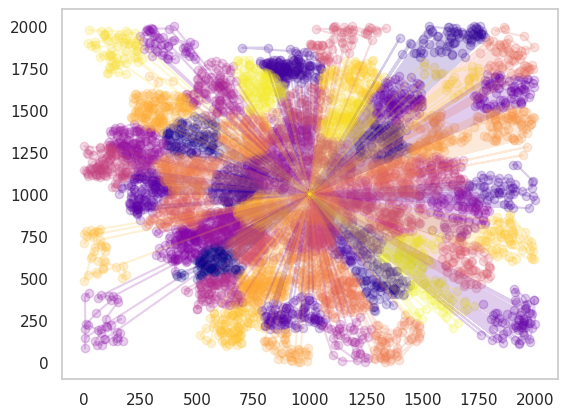

In [ ]:
plotter(df_test_1_100, Antwerp1_max)

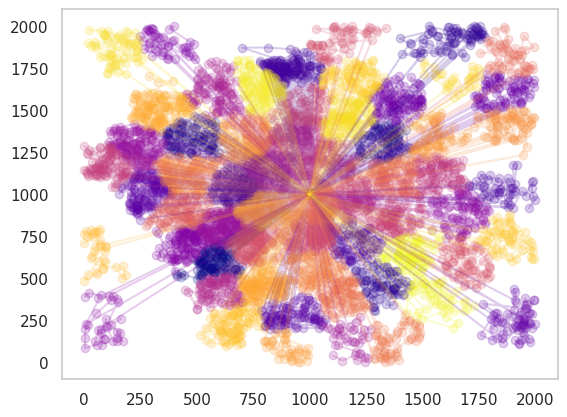

In [ ]:
plotter(df_test_1_50, Antwerp1_max)

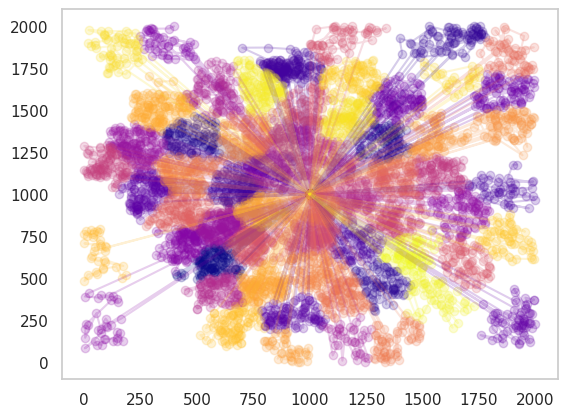

In [ ]:
plotter(df_test_1_20, Antwerp1_max)

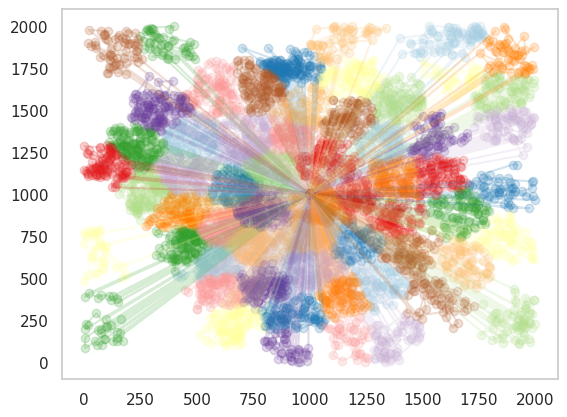

In [ ]:
plotter(df_test_1_100, Antwerp1_max)

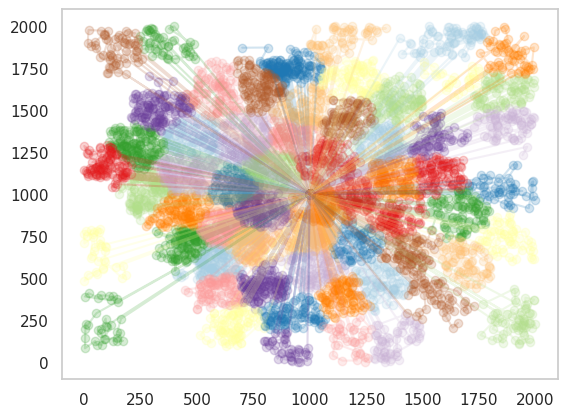

In [ ]:
plotter(df_test_1_50, Antwerp1_max)

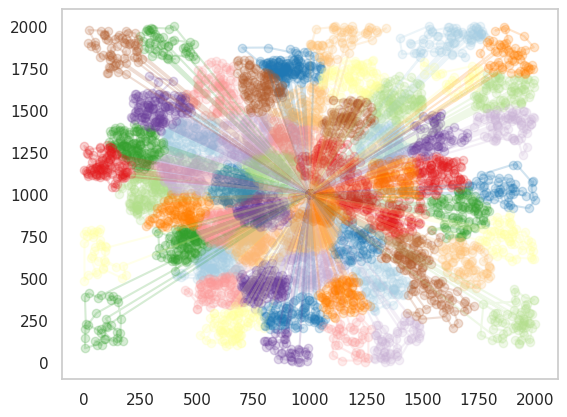

In [ ]:
plotter(df_test_1_20, Antwerp1_max)

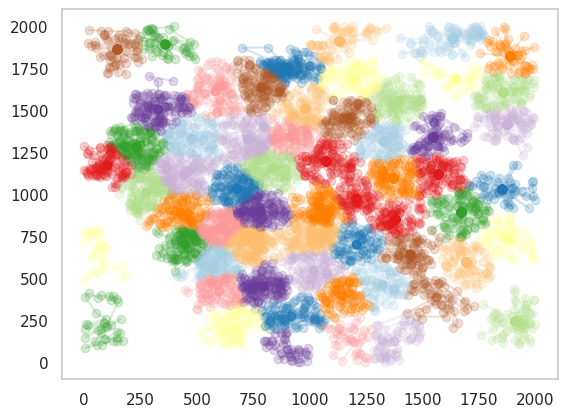

In [ ]:
plotter(df_test_1_100, Antwerp1_max)

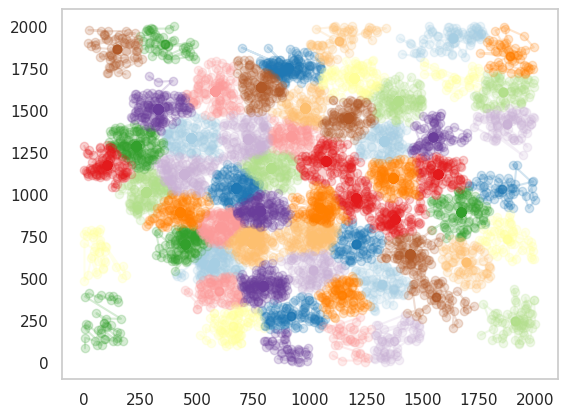

In [ ]:
plotter(df_test_1_50, Antwerp1_max)

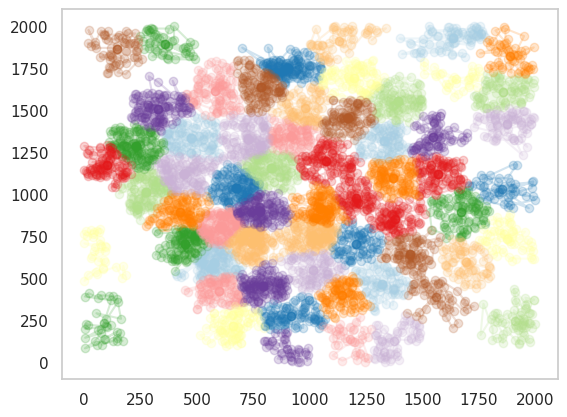

In [ ]:
plotter(df_test_1_20, Antwerp1_max)

## Best Route for each

In [ ]:
# Antwerp1
# Antwerp2
# Brussels1
# Brussels2
# Flanders1
# Flanders2
# Ghent1
# Ghent2
# Leuven1
# Leuven2

In [ ]:
centroid_file_Antwerp1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp1_centroid.csv'
centroid_file_Antwerp2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp2_centroid.csv'
centroid_file_Brussels1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Brussels1_centroid.csv'
centroid_file_Brussels2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Brussels2_centroid.csv'
centroid_file_Flanders1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Flanders1_centroid.csv'
centroid_file_Flanders2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Flanders2_centroid.csv'
centroid_file_Ghent1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Ghent1_centroid.csv'
centroid_file_Ghent2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Ghent2_centroid.csv'
centroid_file_Leuven1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Leuven1_centroid.csv'
centroid_file_Leuven2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Leuven2_centroid.csv'

In [ ]:
depot_file_Antwerp1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp1_depot.csv'
depot_file_Antwerp2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Antwerp2_depot.csv'
depot_file_Brussels1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Brussels1_depot.csv'
depot_file_Brussels2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Brussels2_depot.csv'
depot_file_Flanders1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Flanders1_depot.csv'
depot_file_Flanders2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Flanders2_depot.csv'
depot_file_Ghent1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Ghent1_depot.csv'
depot_file_Ghent2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Ghent2_depot.csv'
depot_file_Leuven1 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Leuven1_depot.csv'
depot_file_Leuven2 = '/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing/Leuven2_depot.csv'

In [ ]:
# Antwerp1
Antwerp1 = 'MDAM_Results/Antwerp1/Antwerp1_test_4_vrp_50_MDAM.csv'
# Antwerp2
Antwerp2 = 'MDAM_Results/Antwerp2/Antwerp2_test_4_vrp_50_MDAM.csv'
# Brussels1
Brussels1 = 'MDAM_Results/Brussels1/Brussels1_test_4_vrp_50_MDAM.csv'
# Brussels2
Brussels2 = 'MDAM_Results/Brussels2/Brussels2_test_4_vrp_50_MDAM.csv'
# Flanders1
Flanders1 = 'MDAM_Results/Flanders1/Flanders1_test_4_vrp_20_MDAM.csv'
# Flanders2
Flanders2 = 'MDAM_Results/Flanders2/Flanders2_test_4_vrp_20_MDAM.csv'
# Ghent1
Ghent1 = 'MDAM_Results/Ghent1/Ghent1_test_4_vrp_50_MDAM.csv'
# Ghent2
Ghent2 = 'MDAM_Results/Ghent2/Ghent2_test_4_vrp_50_MDAM.csv'
# Leuven1
Leuven1 = 'MDAM_Results/Leuven1/Leuven1_test_4_vrp_50_MDAM.csv'
# Leuven2
Leuven2 = 'MDAM_Results/Leuven2/Leuven2_test_4_vrp_50_MDAM.csv'

In [ ]:
_, Antwerp1_merged = massive_function_centroid_MDAM(Antwerp1, centroid_file_Antwerp1, depot_file_Antwerp1)
_, Antwerp2_merged = massive_function_centroid_MDAM(Antwerp2, centroid_file_Antwerp2, depot_file_Antwerp2)
_, Brussels1_merged = massive_function_centroid_MDAM(Brussels1, centroid_file_Brussels1, depot_file_Brussels1)
_, Brussels2_merged = massive_function_centroid_MDAM(Brussels2, centroid_file_Brussels2, depot_file_Brussels2)
_, Flanders1_merged = massive_function_centroid_MDAM(Flanders1, centroid_file_Flanders1, depot_file_Flanders1)
_, Flanders2_merged = massive_function_centroid_MDAM(Flanders2, centroid_file_Flanders2, depot_file_Flanders2)
_, Ghent1_merged = massive_function_centroid_MDAM(Ghent1, centroid_file_Ghent1, depot_file_Ghent1)
_, Ghent2_merged = massive_function_centroid_MDAM(Ghent2, centroid_file_Ghent2, depot_file_Ghent2)
_, Leuven1_merged = massive_function_centroid_MDAM(Leuven1, centroid_file_Leuven1, depot_file_Leuven1)
_, Leuven2_merged = massive_function_centroid_MDAM(Leuven2, centroid_file_Leuven2, depot_file_Leuven2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-115-123bfac894dd>", line 24, in <cell line: 24>
    plt.savefig('Best solutions.png', bbox_inches='tight', format='pdf')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backend_pdf.py", l

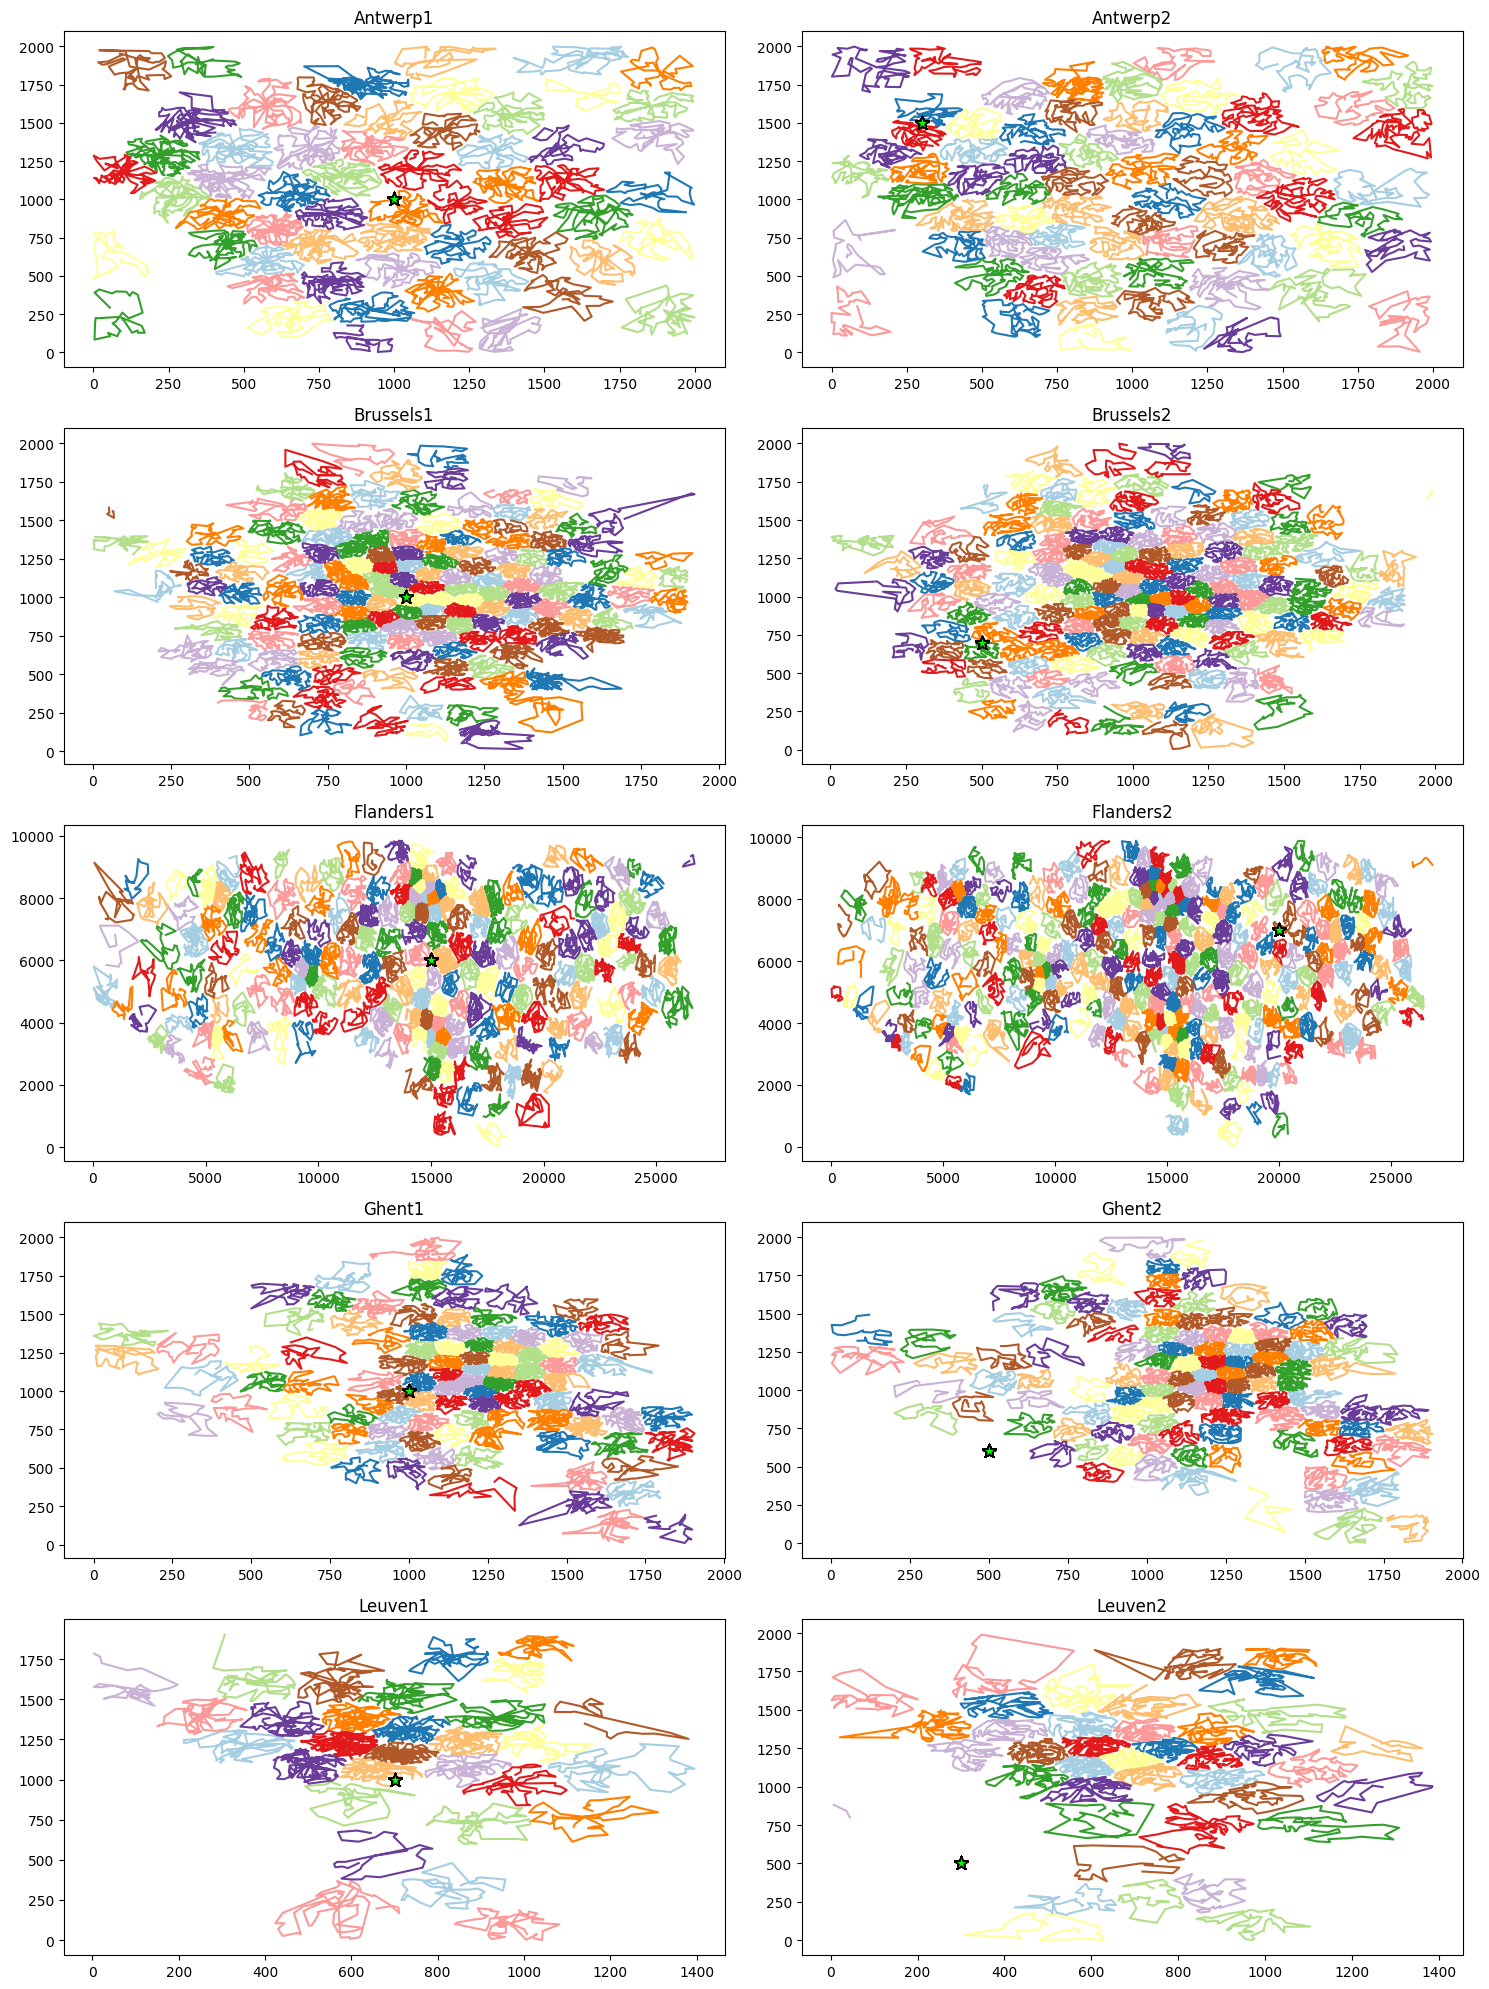

In [ ]:


# Dataframes
dataframes = [Antwerp1_merged, Antwerp2_merged, Brussels1_merged, Brussels2_merged,
              Flanders1_merged, Flanders2_merged, Ghent1_merged, Ghent2_merged,
              Leuven1_merged, Leuven2_merged]

maxes = [Antwerp1_max, Antwerp2_max, Brussels1_max, Brussels2_max,
         Flanders1_max, Flanders2_max, Ghent1_max, Ghent2_max,
         Leuven1_max, Leuven2_max]

# Names for each dataframe
names = ["Antwerp1", "Antwerp2", "Brussels1", "Brussels2", "Flanders1",
         "Flanders2", "Ghent1", "Ghent2", "Leuven1", "Leuven2"]

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjusted to 2 rows and 5 columns of subplots

# Iterate over the dataframes, maxes, names, and subplots
for df, max_value, name, ax in zip(dataframes, maxes, names, axs.ravel()):
    plt.sca(ax)  # Set the current axis to ax
    plotter(df, max_value)
    ax.set_title(name)  # Set title for each subplot

plt.tight_layout()
plt.savefig('Best solutions.png', bbox_inches='tight', format='pdf')


# Plotting Function for Costs

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/Excel Files

/content/drive/MyDrive/Diss_Code/Final_Results/Excel Files


In [ ]:
df = pd.read_excel('Format for results.xlsx', sheet_name='All pd')

In [ ]:
df_Antwerp1 = df[df['Dataset '] == 'Antwerp1']
df_Antwerp2 = df[df['Dataset '] == 'Antwerp2']
df_Brussels1 = df[df['Dataset '] == 'Brussels1']
df_Brussels2 = df[df['Dataset '] == 'Brussels2']
df_Flanders1 = df[df['Dataset '] == 'Flanders1']
df_Flanders2 = df[df['Dataset '] == 'Flanders2']
df_Ghent1 = df[df['Dataset '] == 'Ghent1']
df_Ghent2 = df[df['Dataset '] == 'Ghent2']
df_Leuven1 = df[df['Dataset '] == 'Leuven1']
df_Leuven2 = df[df['Dataset '] == 'Leuven2']

## All Plot

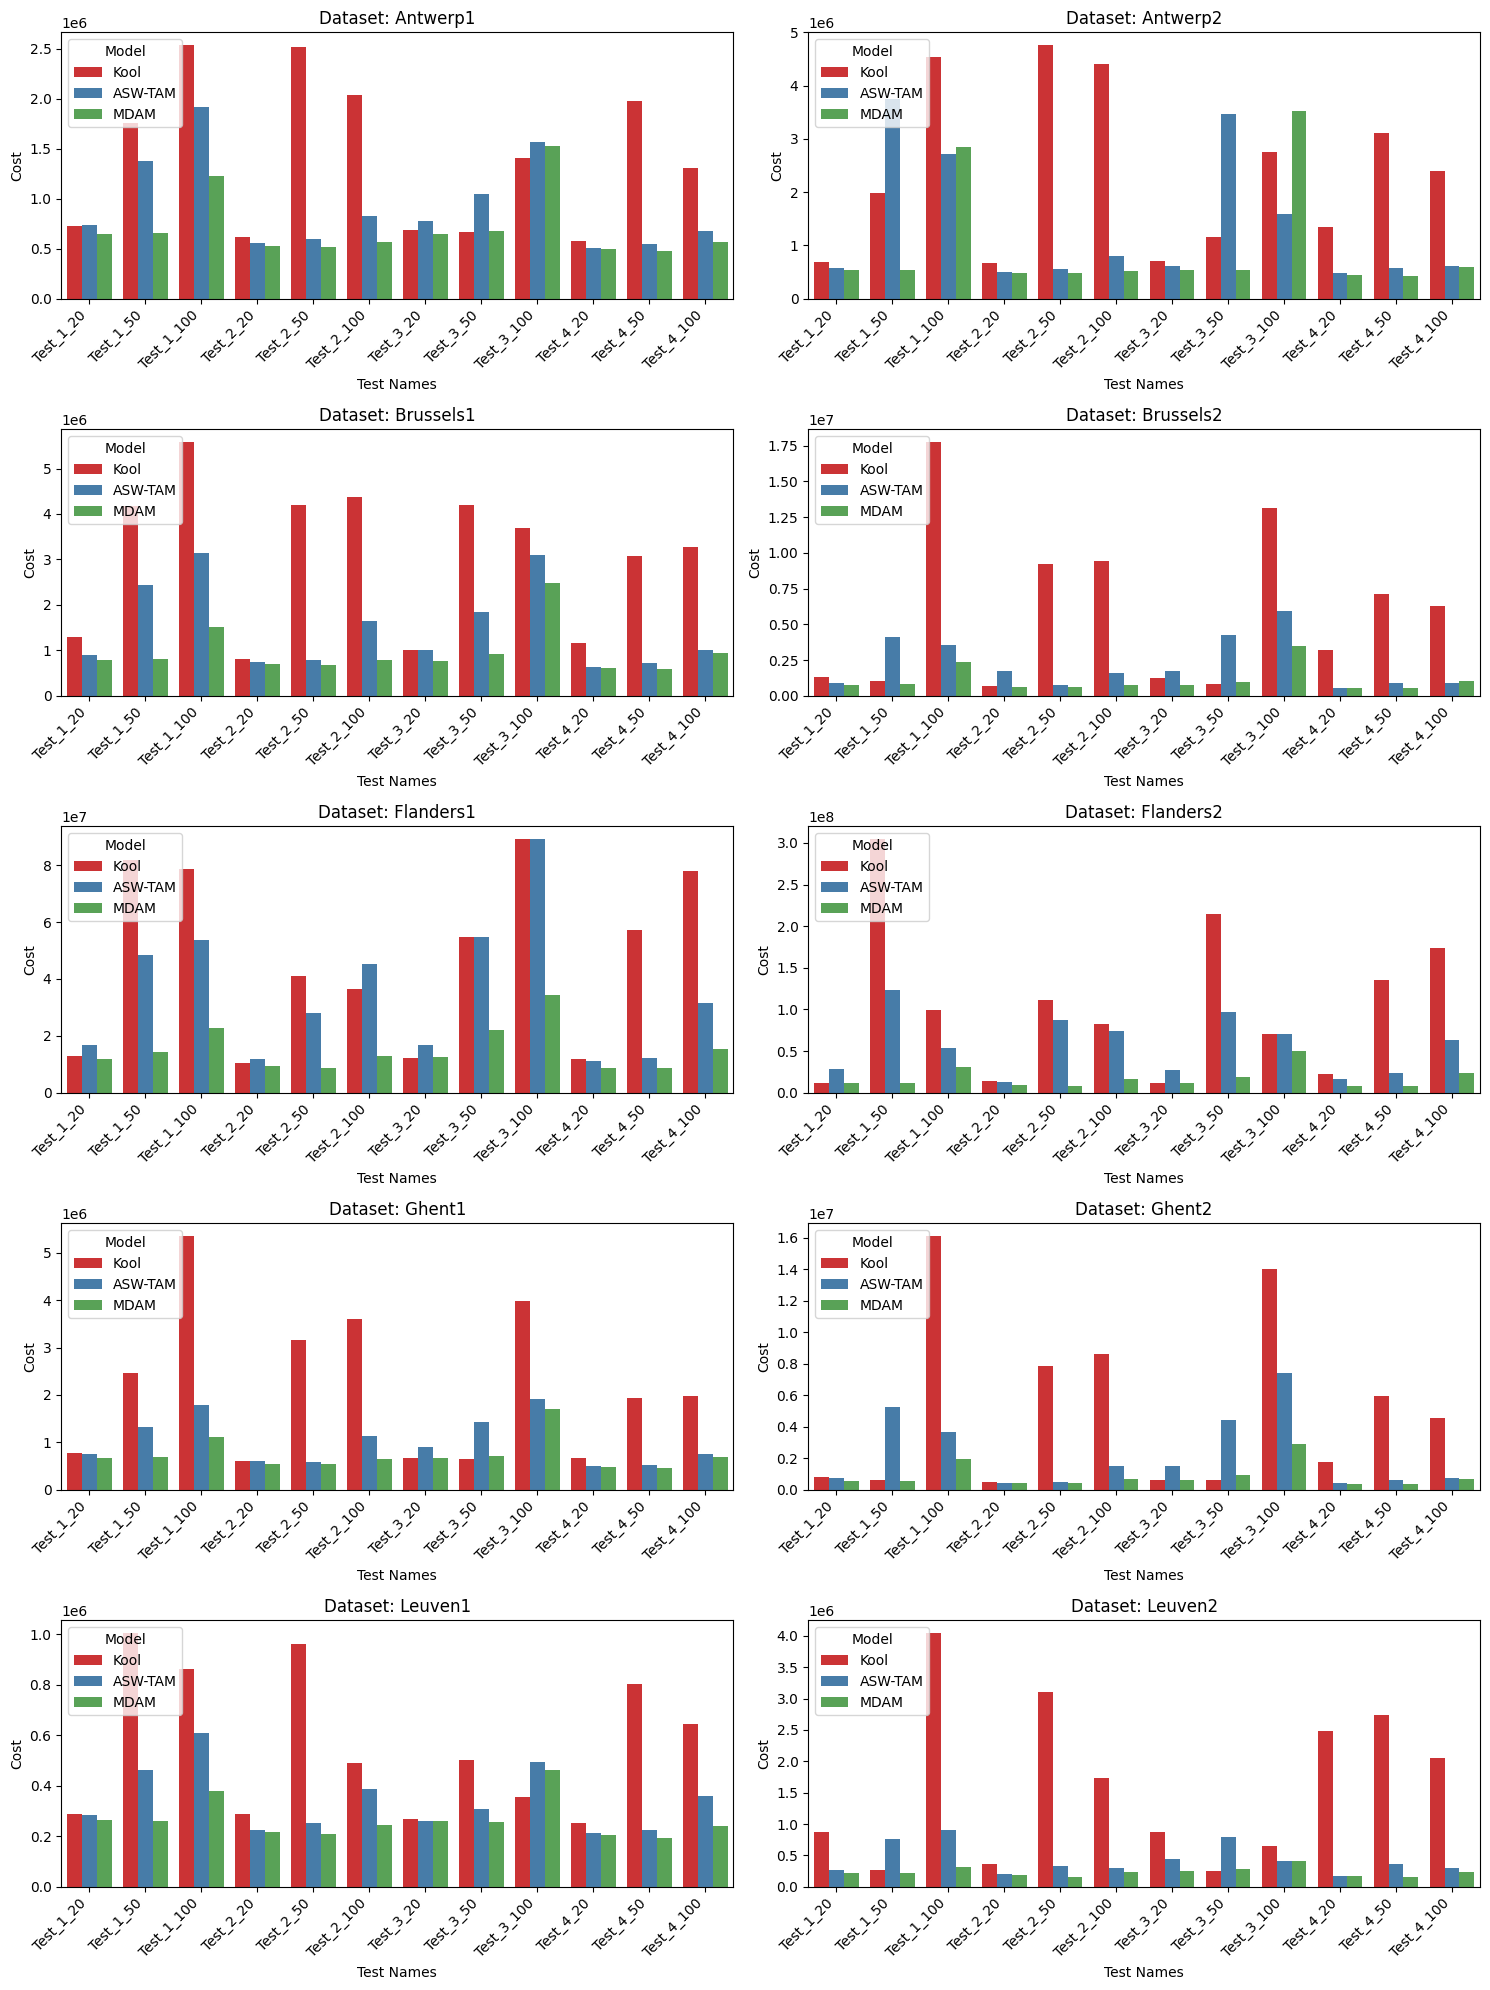

In [ ]:
def bar_plot_cost_plotter(df, ax):
    melted_df = pd.melt(df, id_vars=['Model', 'Dataset '], value_vars=['Test_1_20', 'Test_1_50', 'Test_1_100',
                                                                        'Test_2_20', 'Test_2_50', 'Test_2_100',
                                                                        'Test_3_20', 'Test_3_50', 'Test_3_100',
                                                                        'Test_4_20', 'Test_4_50', 'Test_4_100'],
                        var_name='Test', value_name='Value')
    # Define a custom color palette
    custom_palette = sns.color_palette("Set1", n_colors=len(melted_df['Model'].unique()))

    sns.barplot(data=melted_df, x='Test', y='Value', hue='Model', ax=ax, palette=custom_palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('Test Names')
    ax.set_ylabel('Cost')
    ax.set_title(f'Dataset: {df.iloc[0]["Dataset "]}')
    ax.legend(title='Model', loc='upper left')

# Create a figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

dfs = [df_Antwerp1, df_Antwerp2, df_Brussels1, df_Brussels2, df_Flanders1, df_Flanders2,
       df_Ghent1, df_Ghent2, df_Leuven1, df_Leuven2]

for i, ax in enumerate(axes.flat):
    if i < len(dfs):
        bar_plot_cost_plotter(dfs[i], ax)
    else:
        ax.axis('off')  # Turn off extra subplots

plt.tight_layout()
plt.savefig('subplot_bar_plots.pdf', bbox_inches='tight', format='pdf')

## Optimality Gap Plot

In [ ]:
df = pd.read_excel('Format for results.xlsx', sheet_name='Optimality Gaps pd')

In [ ]:
df_Antwerp1 = df[df['Dataset '] == 'Antwerp1']
df_Antwerp2 = df[df['Dataset '] == 'Antwerp2']
df_Brussels1 = df[df['Dataset '] == 'Brussels1']
df_Brussels2 = df[df['Dataset '] == 'Brussels2']
df_Flanders1 = df[df['Dataset '] == 'Flanders1']
df_Flanders2 = df[df['Dataset '] == 'Flanders2']
df_Ghent1 = df[df['Dataset '] == 'Ghent1']
df_Ghent2 = df[df['Dataset '] == 'Ghent2']
df_Leuven1 = df[df['Dataset '] == 'Leuven1']
df_Leuven2 = df[df['Dataset '] == 'Leuven2']

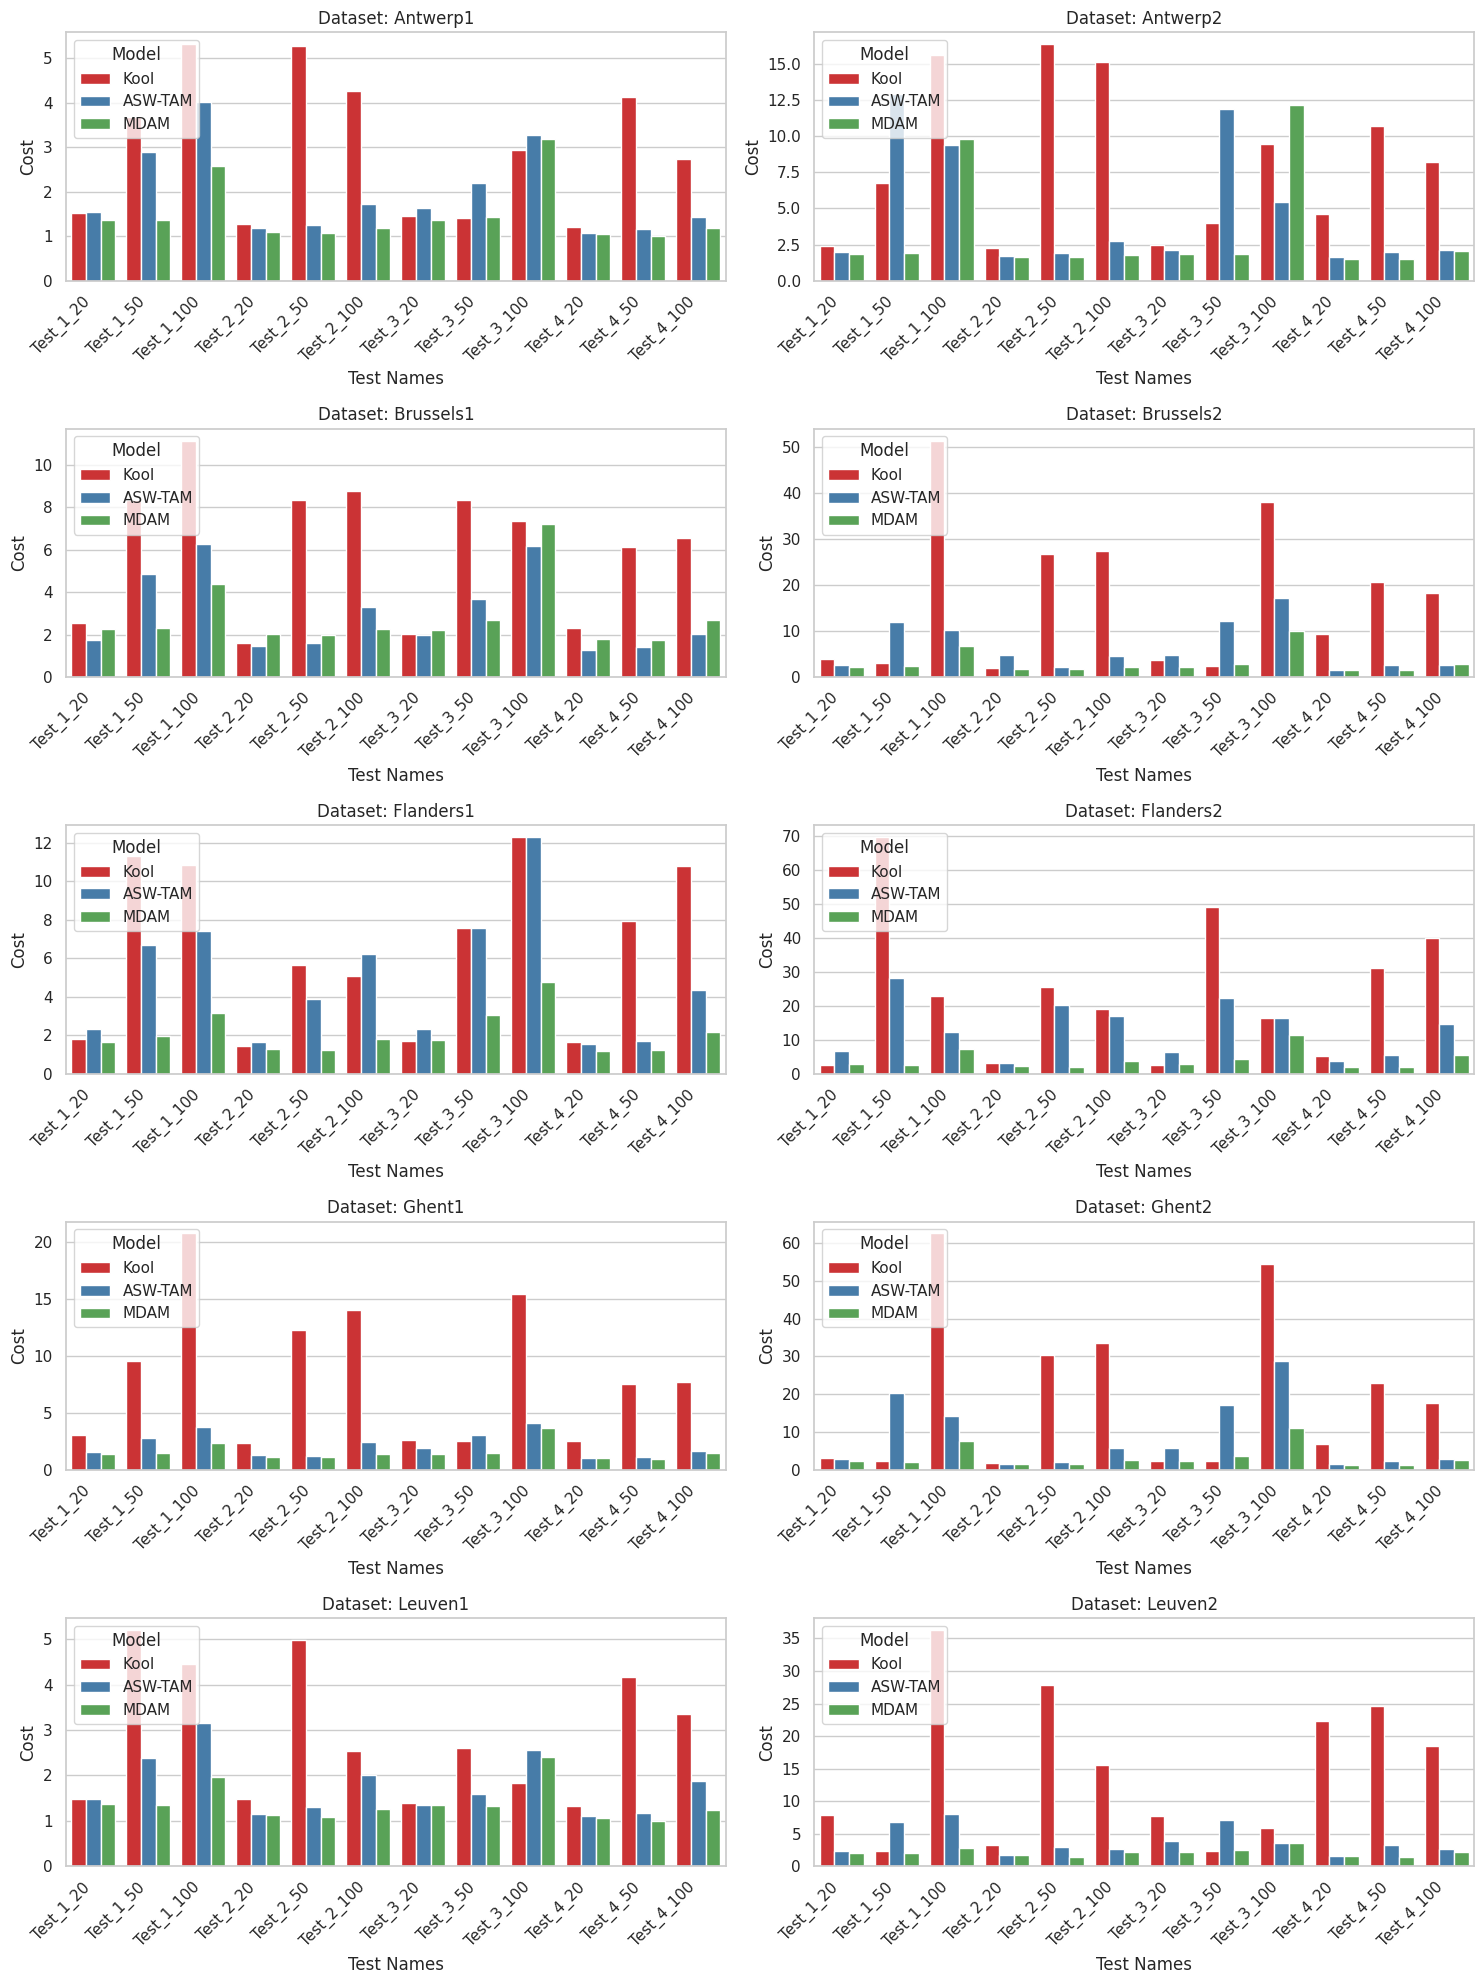

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

dfs = [df_Antwerp1, df_Antwerp2, df_Brussels1, df_Brussels2, df_Flanders1, df_Flanders2,
       df_Ghent1, df_Ghent2, df_Leuven1, df_Leuven2]

for i, ax in enumerate(axes.flat):
    if i < len(dfs):
        bar_plot_cost_plotter(dfs[i], ax)
    else:
        ax.axis('off')  # Turn off extra subplots

plt.tight_layout()
plt.savefig('optimality_gaps.pdf', bbox_inches='tight', format='pdf')

## Plot for Kool, ASW-TAM, and MDAM seperatley

In [ ]:
df = pd.read_excel('Format for results.xlsx', sheet_name='All pd')

In [ ]:
df_Antwerp1 = df[df['Dataset '] == 'Antwerp1']
df_Antwerp2 = df[df['Dataset '] == 'Antwerp2']
df_Brussels1 = df[df['Dataset '] == 'Brussels1']
df_Brussels2 = df[df['Dataset '] == 'Brussels2']
df_Flanders1 = df[df['Dataset '] == 'Flanders1']
df_Flanders2 = df[df['Dataset '] == 'Flanders2']
df_Ghent1 = df[df['Dataset '] == 'Ghent1']
df_Ghent2 = df[df['Dataset '] == 'Ghent2']
df_Leuven1 = df[df['Dataset '] == 'Leuven1']
df_Leuven2 = df[df['Dataset '] == 'Leuven2']

#### Function

In [ ]:
def bar_plot_cost_plotter(df, ax, model):
    df_new = df[df['Model'] == model]

    melted_df_new = pd.melt(df_new, id_vars='Dataset ', value_vars=['Test_1_20', 'Test_1_50', 'Test_1_100',
                                                            'Test_2_20', 'Test_2_50', 'Test_2_100',
                                                            'Test_3_20', 'Test_3_50', 'Test_3_100',
                                                            'Test_4_20', 'Test_4_50', 'Test_4_100'],
                        var_name='Test', value_name='Value')


    # Define a custom color palette
    custom_palette = sns.color_palette("Set2")

    # Create the bar plot with Seaborn
    sns.barplot(data=melted_df_new, x='Test', y='Value',  palette=custom_palette, ax=ax)
    # Set x-axis tick positions and labels
    xtick_positions = range(len(melted_df_new['Test'].unique()))
    xtick_labels = melted_df_new['Test'].unique()
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
    ax.set_xlabel('Test Names')
    ax.set_ylabel('Cost')
    ax.set_title(f'{df.iloc[0]["Dataset "]}')

In [ ]:
def bar_plot_cost_plotter(df, ax, model):
    df_new = df[df['Model'] == model]

    melted_df_new = pd.melt(df_new, id_vars='Dataset ', value_vars=['Test_1_20', 'Test_1_50', 'Test_1_100',
                                                            'Test_2_20', 'Test_2_50', 'Test_2_100',
                                                            'Test_3_20', 'Test_3_50', 'Test_3_100',
                                                            'Test_4_20', 'Test_4_50', 'Test_4_100'],
                        var_name='Test', value_name='Value')

    # Extract the first 5 characters from the 'Test' column as 'Test_Type'
    melted_df_new['Test_Type'] = melted_df_new['Test'].apply(lambda x: x[:6])

    # Define a custom color palette
    custom_palette = sns.color_palette("Set2")

    # Create the bar plot with Seaborn
    sns.barplot(data=melted_df_new, x='Test', y='Value', hue='Test_Type', dodge=False, palette=custom_palette, ax=ax)

    # Set x-axis tick positions and labels

    xtick_labels = melted_df_new['Test'].unique()

    xtick_labels_new = []

    for xtick in xtick_labels:
        xtick_labels_new.append(xtick[7:])

    xtick_positions = range((12))

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels_new, rotation=45)

    ax.set_xlabel('Pretrained Instance Size')
    ax.set_ylabel('Cost')
    ax.set_title(f'{df.iloc[0]["Dataset "]}')
    ax.legend(title='Test', loc='upper left')


# Call the function with your DataFrame and desired model
# bar_plot_cost_plotter(your_dataframe, 'desired_model_name')


#### Kool

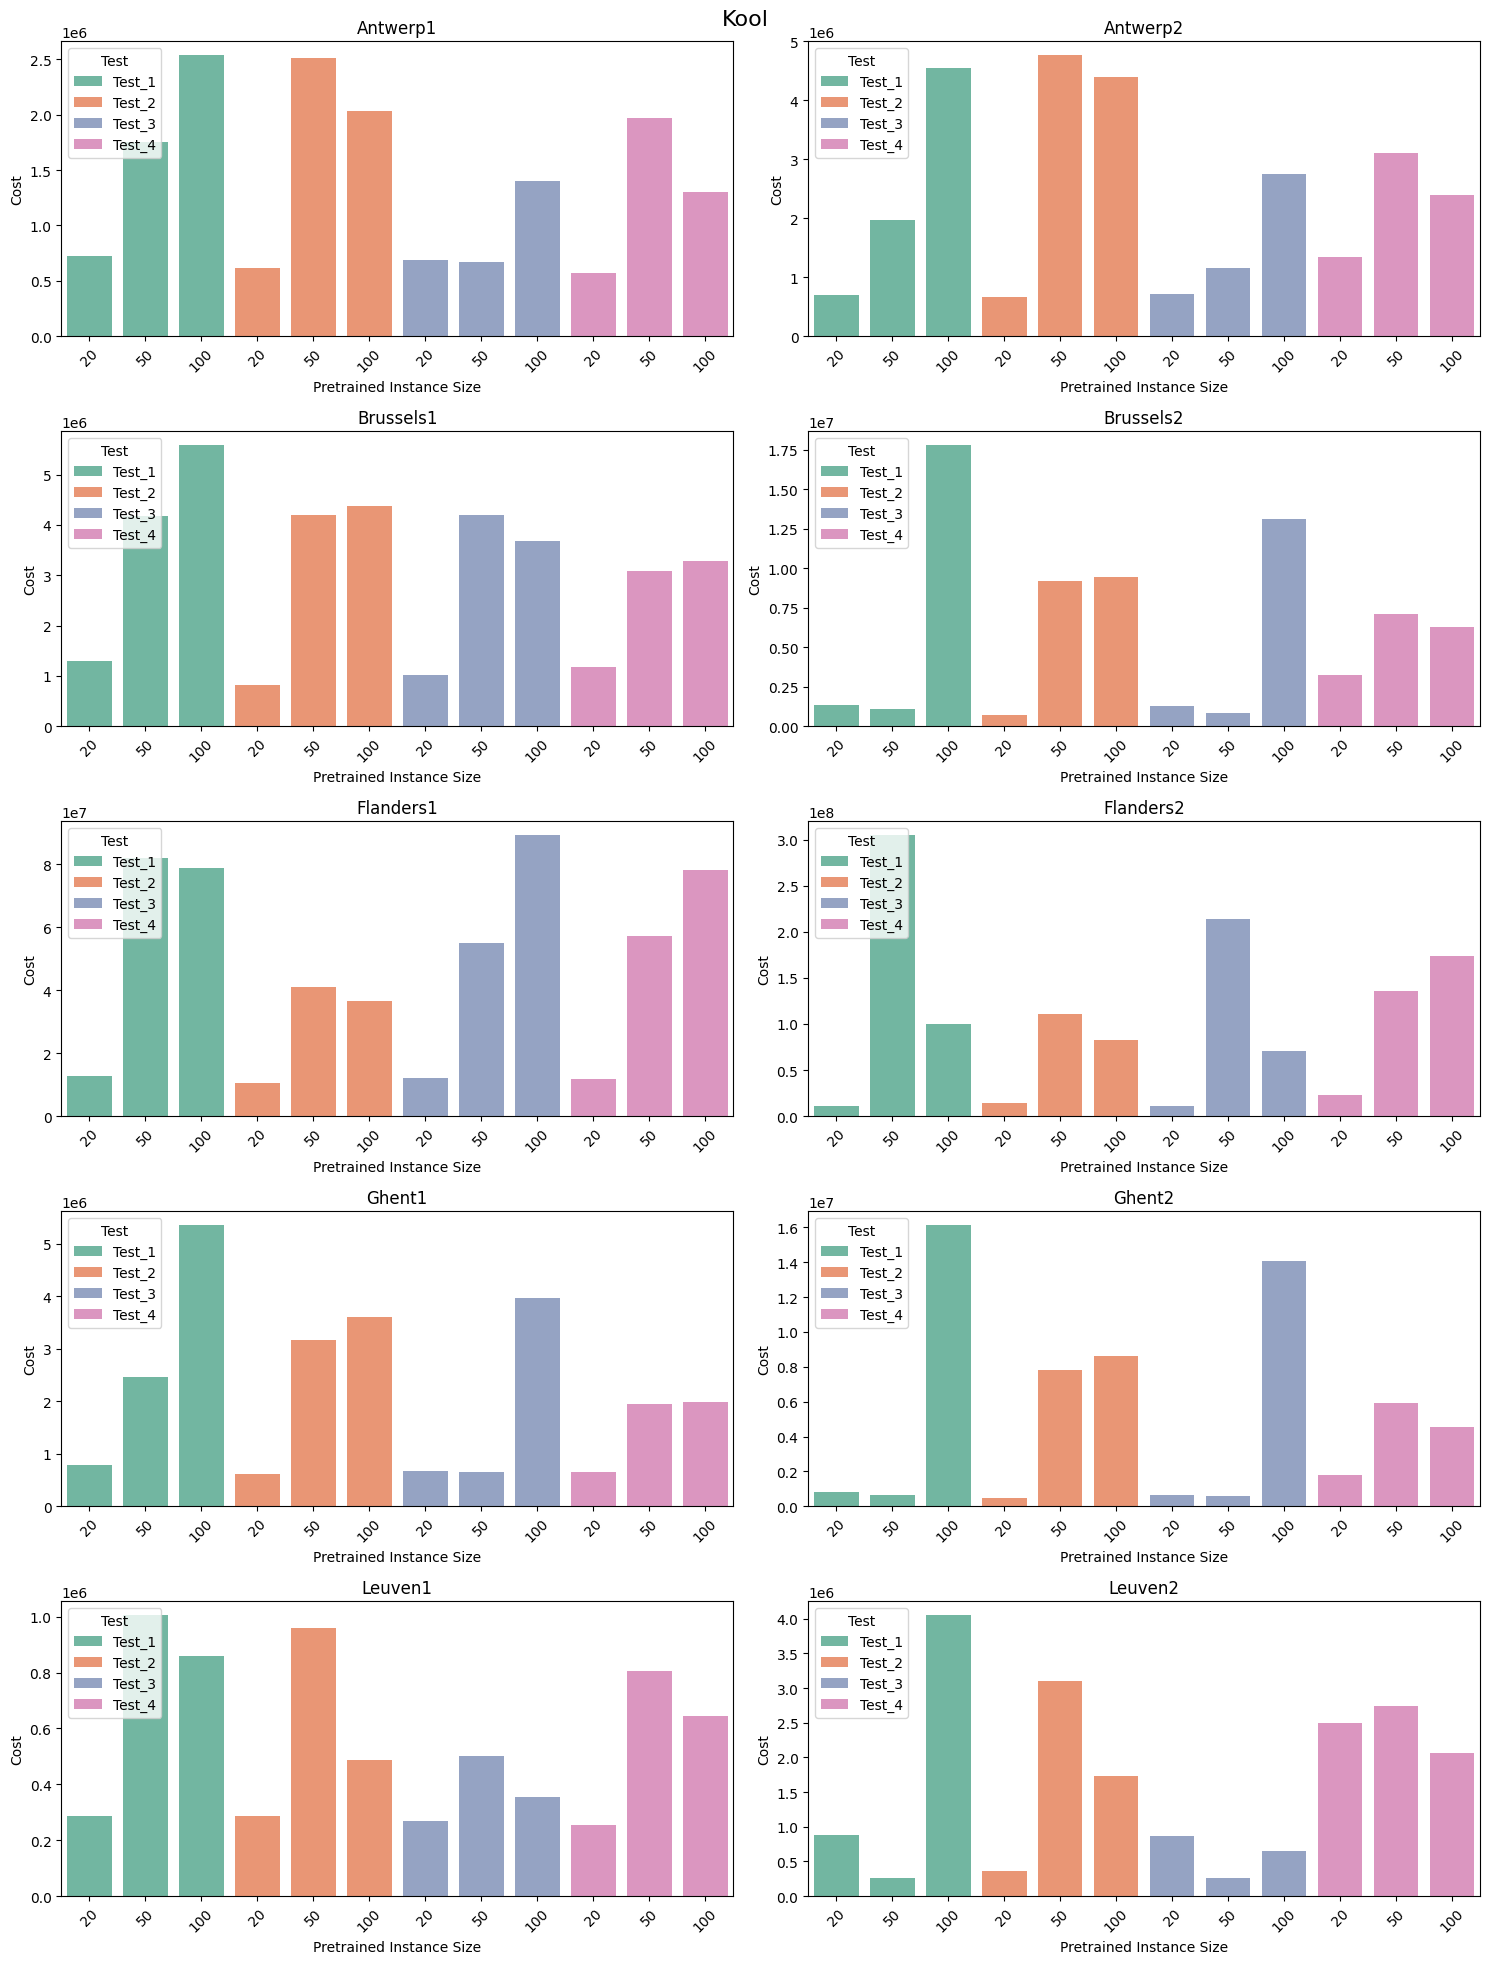

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

dfs = [df_Antwerp1, df_Antwerp2, df_Brussels1, df_Brussels2, df_Flanders1, df_Flanders2,
       df_Ghent1, df_Ghent2, df_Leuven1, df_Leuven2]

for i, ax in enumerate(axes.flat):
    if i < len(dfs):
        bar_plot_cost_plotter(dfs[i], ax, 'Kool')
    else:
        ax.axis('off')  # Turn off extra subplots

fig.suptitle('Kool', fontsize=16)

plt.tight_layout()
plt.savefig('Kool plot.pdf', bbox_inches='tight', format='pdf')

#### MDAM

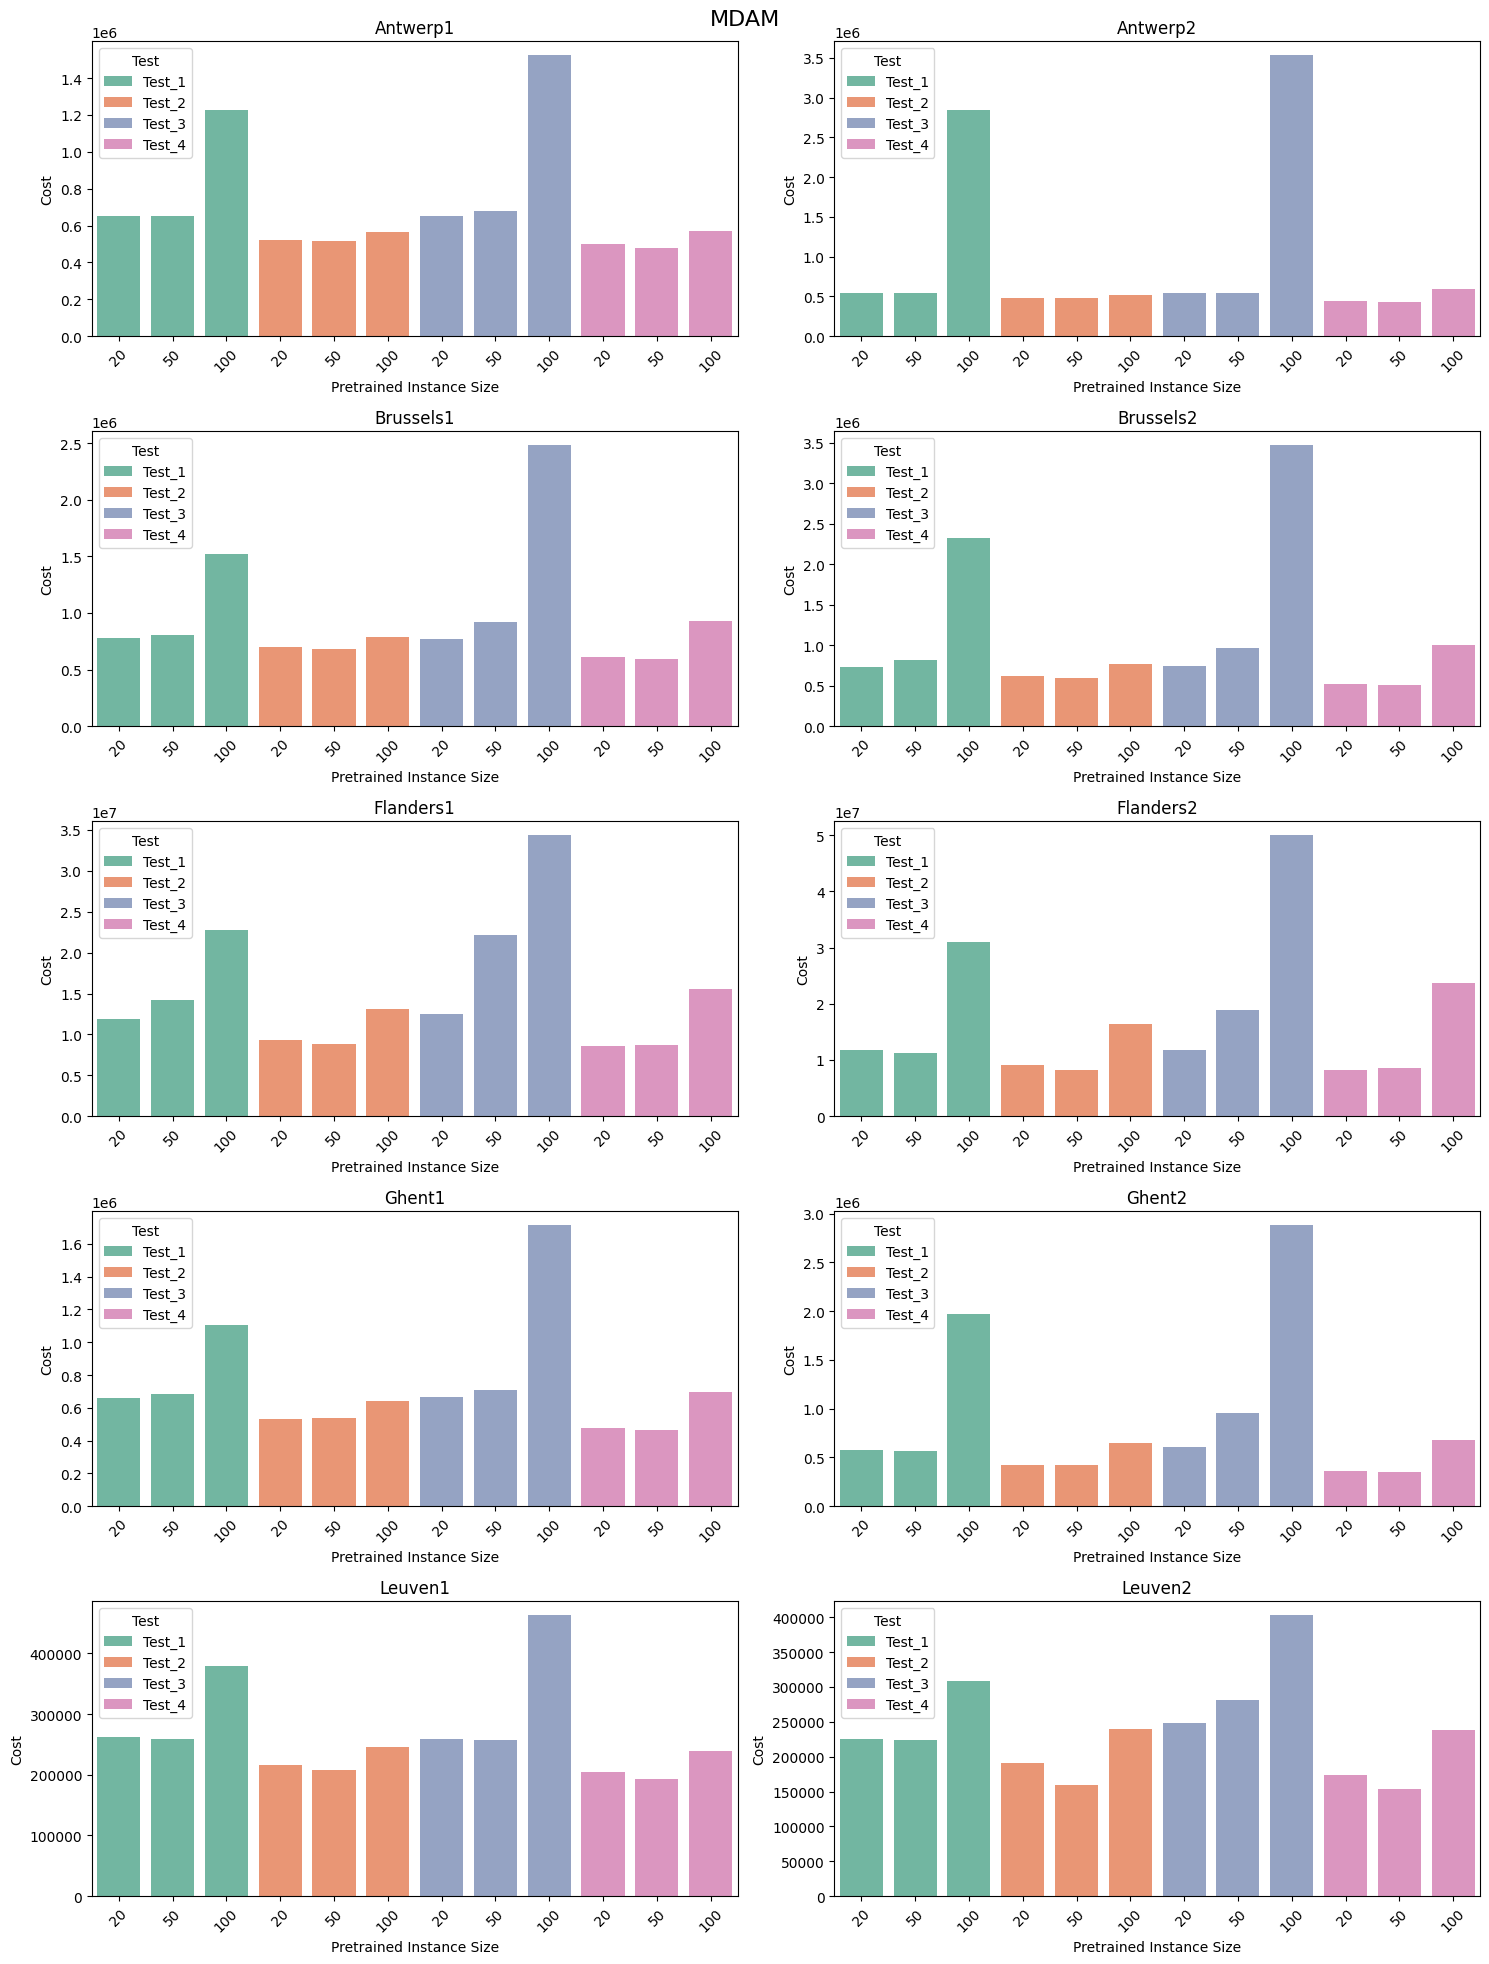

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

dfs = [df_Antwerp1, df_Antwerp2, df_Brussels1, df_Brussels2, df_Flanders1, df_Flanders2,
       df_Ghent1, df_Ghent2, df_Leuven1, df_Leuven2]

for i, ax in enumerate(axes.flat):
    if i < len(dfs):
        bar_plot_cost_plotter(dfs[i], ax, 'MDAM')
    else:
        ax.axis('off')  # Turn off extra subplots

fig.suptitle('MDAM', fontsize=16)

plt.tight_layout()
plt.savefig('MDAM plot.pdf', bbox_inches='tight', format='pdf')

#### ASW-TAM

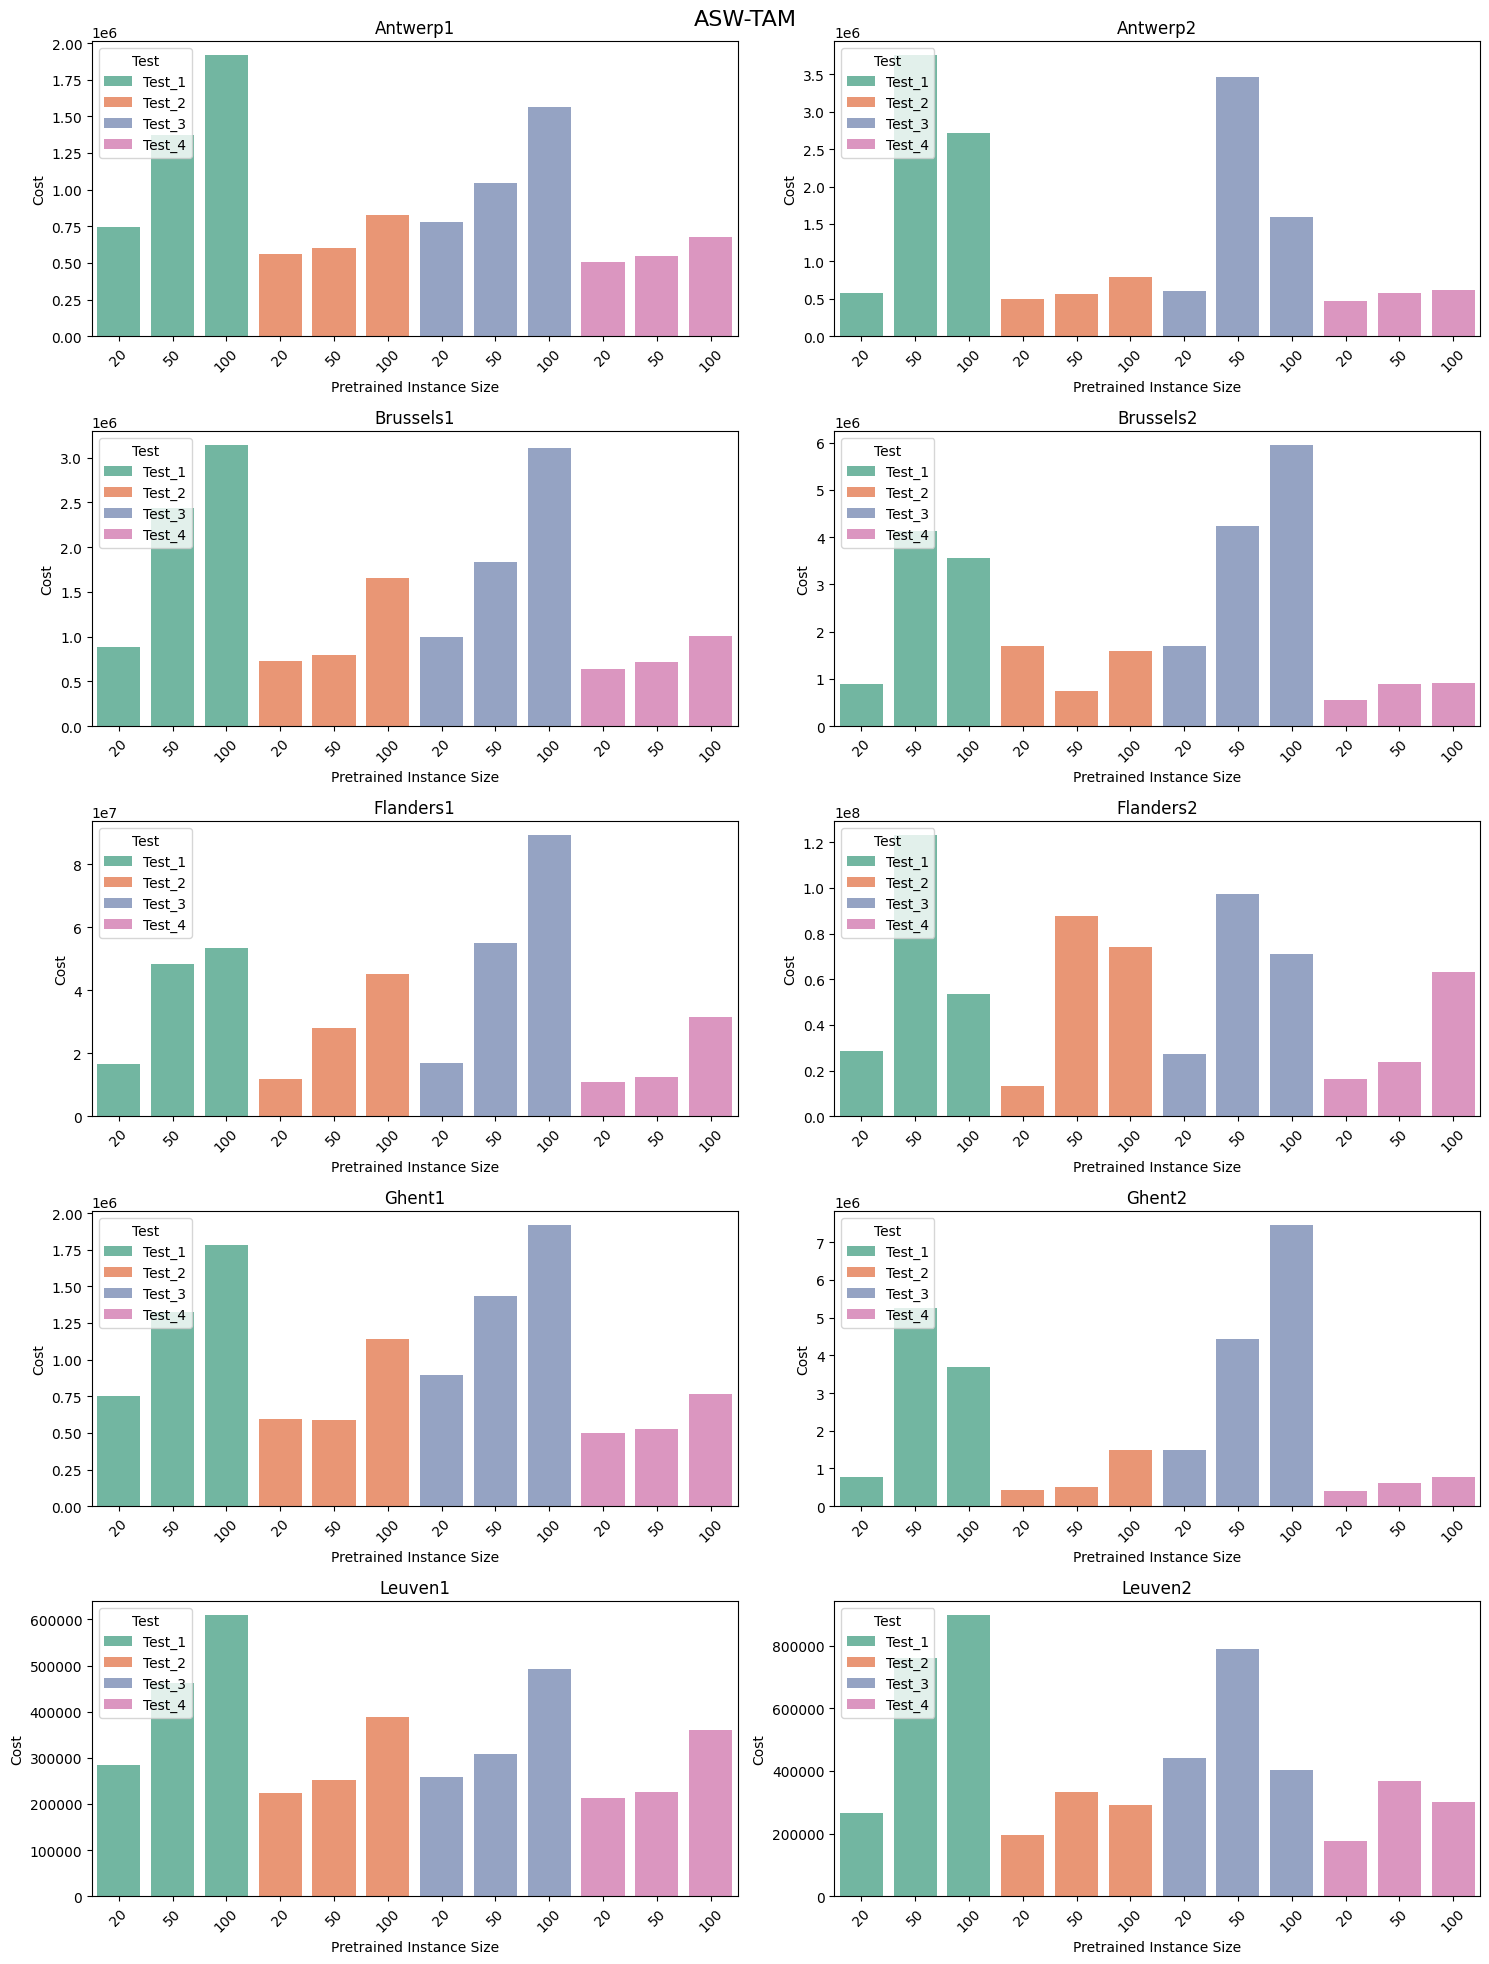

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

dfs = [df_Antwerp1, df_Antwerp2, df_Brussels1, df_Brussels2, df_Flanders1, df_Flanders2,
       df_Ghent1, df_Ghent2, df_Leuven1, df_Leuven2]

for i, ax in enumerate(axes.flat):
    if i < len(dfs):
        bar_plot_cost_plotter(dfs[i], ax, 'ASW-TAM')
    else:
        ax.axis('off')  # Turn off extra subplots

fig.suptitle('ASW-TAM', fontsize=16)

plt.tight_layout()
plt.savefig('ASW-TAM.pdf', bbox_inches='tight', format='pdf')

# Plotting Functions for Cost Comparisons Between Models

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/Excel Files

/content/drive/MyDrive/Diss_Code/Final_Results/Excel Files


In [ ]:
df = pd.read_excel('Format for results.xlsx', sheet_name='All pd')

In [ ]:
df['Average'] = df[['Test_1_20',	'Test_1_50',	'Test_1_100',
                    'Test_2_20',	'Test_2_50',	'Test_2_100',
                    'Test_3_20',	'Test_3_50',	'Test_3_100',
                    'Test_4_20',	'Test_4_50',	'Test_4_100']].mean(axis=1)

df['Best'] = df[['Test_1_20',	'Test_1_50',	'Test_1_100',
                    'Test_2_20',	'Test_2_50',	'Test_2_100',
                    'Test_3_20',	'Test_3_50',	'Test_3_100',
                    'Test_4_20',	'Test_4_50',	'Test_4_100']].min(axis=1)

df['Std_Dev'] = df[['Test_1_20',	'Test_1_50',	'Test_1_100',
                    'Test_2_20',	'Test_2_50',	'Test_2_100',
                    'Test_3_20',	'Test_3_50',	'Test_3_100',
                    'Test_4_20',	'Test_4_50',	'Test_4_100']].std(axis=1)

## Average

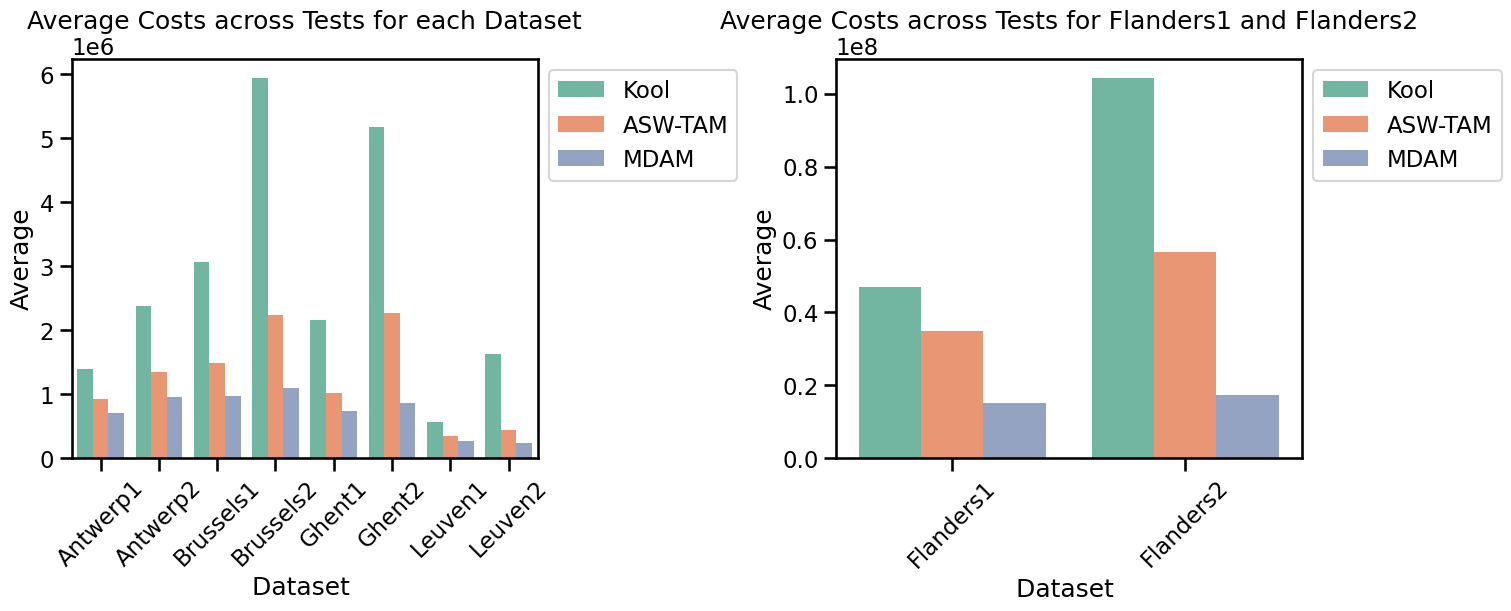

In [ ]:
# Set up a 2-row, 1-column subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# Filter the data for the first plot (excluding Flanders1 and Flanders2)
df_sub1 = df[(df['Dataset '] != 'Flanders1') & (df['Dataset '] != 'Flanders2')]

# Create the first barplot
sns.barplot(
    x='Dataset ',
    y='Average',
    hue='Model',
    data=df_sub1,
    palette='Set2',
    ax=axes[0]  # This specifies which subplot to draw on
)
axes[0].set_title("Average Costs across Tests for each Dataset")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Filter the data for the second plot (only Flanders1 and Flanders2)
df_sub2 = df[(df['Dataset '] == 'Flanders1') | (df['Dataset '] == 'Flanders2')]

# Create the second barplot
sns.barplot(
    x='Dataset ',
    y='Average',
    hue='Model',
    data=df_sub2,
    palette='Set2',
    ax=axes[1]  # This specifies which subplot to draw on
)
axes[1].set_title("Average Costs across Tests for Flanders1 and Flanders2")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the combined figure
plt.savefig('Average Costs across Tests Combined.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
# plt.figure(figsize=(10, 6))
# bar = sns.barplot(x=df[(df['Dataset '] != 'Flanders1') & (df['Dataset '] != 'Flanders2')]['Dataset '], y='Average', hue='Model', data=df, palette='Set2')
# plt.title("Average Costs across Tests for each Dataset")
# plt.xticks(rotation=45)
# bar.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.savefig('Average Costs across Tests for each Dataset.pdf', bbox_inches='tight', format='pdf')

In [ ]:
# plt.figure(figsize=(8, 6))
# bar = sns.barplot(x=df[(df['Dataset '] == 'Flanders1') | (df['Dataset '] == 'Flanders2')]['Dataset '], y='Average', hue='Model', data=df, palette='Set2')
# plt.title("Average Costs across Tests for Flanders1 and Flanders2")
# plt.xticks(rotation=45)
# bar.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.savefig('Average Costs across Tests for Flanders1 and Flanders2.pdf', bbox_inches='tight', format='pdf')

## Best

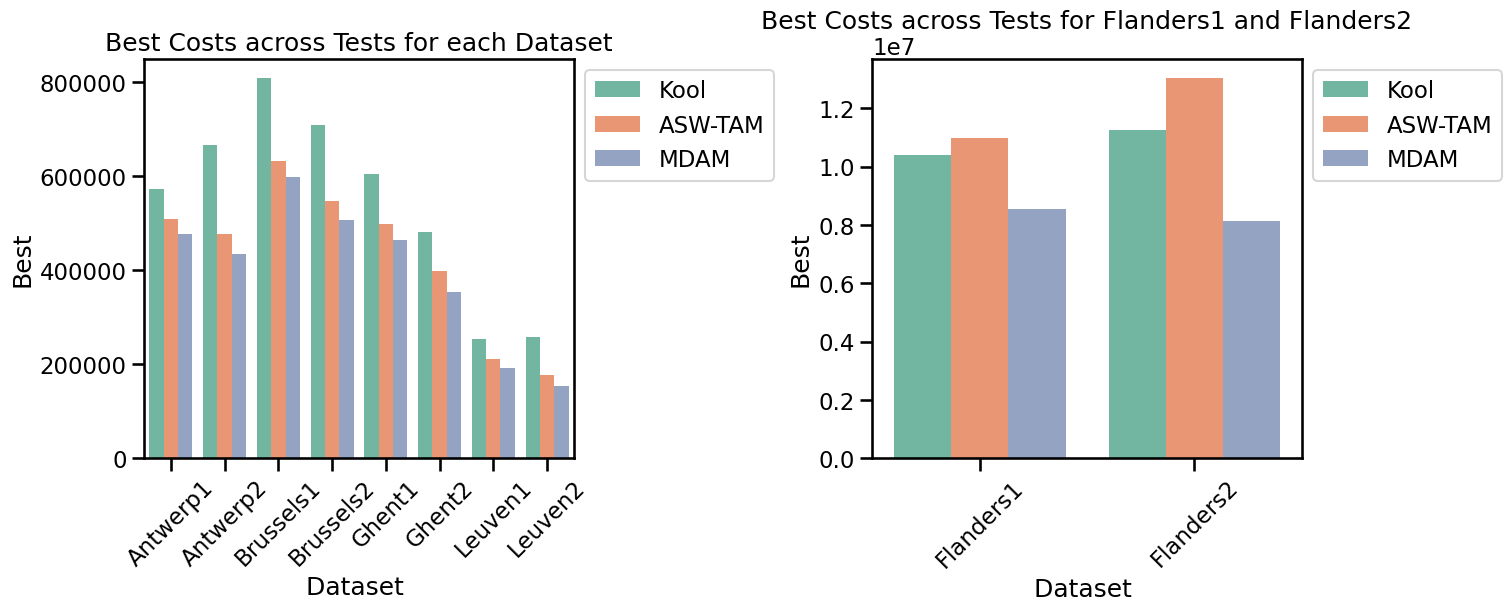

In [ ]:
# Set up a 2-row, 1-column subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# Filter the data for the first plot (excluding Flanders1 and Flanders2)
df_sub1 = df[(df['Dataset '] != 'Flanders1') & (df['Dataset '] != 'Flanders2')]

# Create the first barplot
sns.barplot(
    x='Dataset ',
    y='Best',
    hue='Model',
    data=df_sub1,
    palette='Set2',
    ax=axes[0]  # This specifies which subplot to draw on
)
axes[0].set_title("Best Costs across Tests for each Dataset")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Filter the data for the second plot (only Flanders1 and Flanders2)
df_sub2 = df[(df['Dataset '] == 'Flanders1') | (df['Dataset '] == 'Flanders2')]

# Create the second barplot
sns.barplot(
    x='Dataset ',
    y='Best',
    hue='Model',
    data=df_sub2,
    palette='Set2',
    ax=axes[1]  # This specifies which subplot to draw on
)
axes[1].set_title("Best Costs across Tests for Flanders1 and Flanders2")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the combined figure
plt.savefig('Best Costs across Tests Combined.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
# plt.figure(figsize=(10, 6))
# bar = sns.barplot(x=df[(df['Dataset '] != 'Flanders1') & (df['Dataset '] != 'Flanders2')]['Dataset '], y='Best', hue='Model', data=df, palette='Set2')
# plt.title("Best Costs across Tests for each Dataset")
# plt.xticks(rotation=45)
# bar.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.savefig('Best Costs across Tests for each Dataset.pdf', bbox_inches='tight', format='pdf')

In [ ]:
# plt.figure(figsize=(8, 6))
# bar = sns.barplot(x=df[(df['Dataset '] == 'Flanders1') | (df['Dataset '] == 'Flanders2')]['Dataset '], y='Best', hue='Model', data=df, palette='Set2')
# plt.title("Best Costs across Tests for Flanders1 and Flanders2")
# plt.xticks(rotation=45)
# bar.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.savefig('Best Costs across Tests for Flanders1 and Flanders2.pdf', bbox_inches='tight', format='pdf')

## Best models countplot

In [ ]:
df = pd.read_excel('Format for results.xlsx', sheet_name='Best')

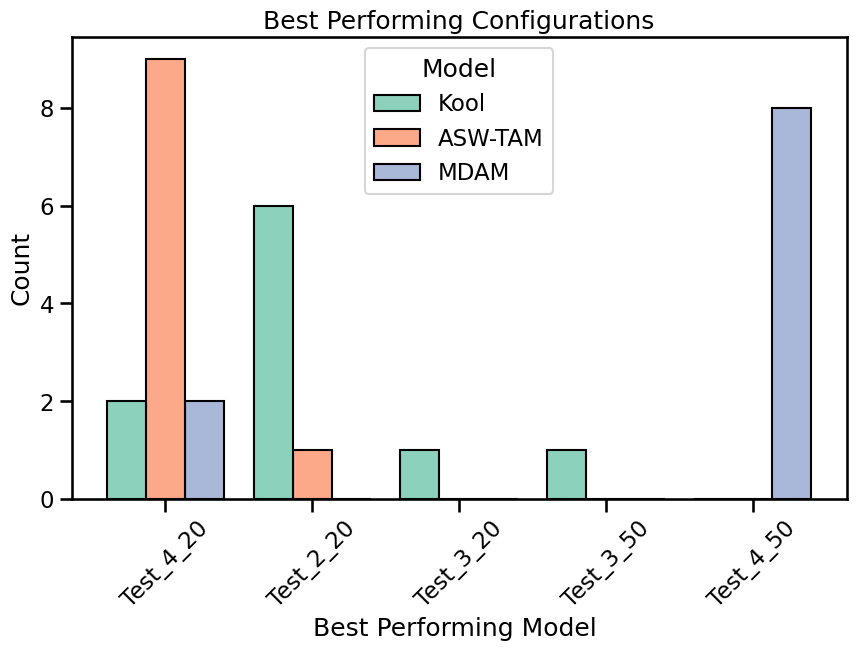

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Best Performing Model ', hue='Model',  multiple="dodge", shrink=0.8)
plt.title("Best Performing Configurations")
plt.xticks(rotation=45)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('Best Performing Configurations', bbox_inches='tight', format='pdf')

# Benchmarks

## Function

In [ ]:
def poop():
  empty_dic = {}

  # Create an empty DataFrame to store the data
  combined_df = pd.DataFrame()

  # Get the current directory
  current_directory = os.getcwd()

  # List subdirectories (folders) in the current directory
  subdirectories = [item for item in os.listdir(current_directory) if os.path.isdir(item)]

  # Loop through subdirectories
  for subdir in subdirectories:
      subdir_path = os.path.join(current_directory, subdir)

      # List files in the subdirectory
      files_in_subdir = os.listdir(subdir_path)

      # Loop through files in the subdirectory
      for file_name in files_in_subdir:
          file_path = os.path.join(subdir_path, file_name)

          # Check if the file is a CSV file
          if file_name.endswith('.csv'):


              # Open the CSV file and read its content
              df = pd.read_csv(file_path)

              numeric_values = df['Cost'].apply(lambda x: float(x.strip("tensor()")))

              # Store the numeric values in the dictionary
              empty_dic[file_name] = numeric_values.tolist()[0]



  return empty_dic



## Kool

In [ ]:
%cd KOOL_Bench_Results/

In [ ]:
df = pd.DataFrame(poop().items(), columns=['File Name', 'Cost Value'])

In [ ]:
csv_file_path = 'kool bench.csv'  # Adjust the file path as needed
df.to_csv(csv_file_path, index=False)

## MDAM

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/MDAM_Bench_Results

In [ ]:
df = pd.DataFrame(poop().items(), columns=['File Name', 'Cost Value'])

In [ ]:
csv_file_path = 'mdam bench.csv'  # Adjust the file path as needed
df.to_csv(csv_file_path, index=False)

## ASW-TAM

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/STEP_Bench_Results

/content/drive/MyDrive/Diss_Code/Final_Results/STEP_Bench_Results


In [ ]:
df = pd.DataFrame(poop().items(), columns=['File Name', 'Cost Value'])

In [ ]:
csv_file_path = 'step bench.csv'  # Adjust the file path as needed
df.to_csv(csv_file_path, index=False)